# Determinacion del Pico Maximo de Potencia Aparente x ET

Se dispone de los datos del SITEC ordenados cada 15 minutos por Estacion


13/10/2021 12:55

TENGO QUE ARREGLAR Y MEJORAR LOS GRAFICOS CON MATPLOTLIB


In [1]:
# -*- coding: utf-8 -*-
"""
Created on Viernes 8 Octubre 2021 17:43:11 

@author: Daniel Busso
"""

# Plantilla de Pre Procesado

# Cómo importar las librerías
import numpy as np
import pandas as pd
import datetime as dt
import os

# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('fivethirtyeight')

from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf


# Configuración warnings
# ==============================================================================
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Modelado y Forecasting
# ==============================================================================
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
#from xgboost import XGBRegressor

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
#from sklearn.metrics import mean_absolute_percentage_error

#from skforecast.ForecasterAutoreg import ForecasterAutoreg
#from skforecast.ForecasterAutoregMultiOutput import ForecasterAutoregMultiOutput
#from skforecast.model_selection import grid_search_forecaster
#from skforecast.model_selection import time_series_spliter
#from skforecast.model_selection import cv_forecaster
#from skforecast.model_selection import backtesting_forecaster
#from skforecast.model_selection import backtesting_forecaster_intervals

In [3]:
# Configuracion Pandas

pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', -1)
pd.set_option('display.float_format', '{:.6f}'.format)

### Automatizacion de lectura de Archivos Anuales por EETT 
Lectura y creacion del index DateTime para tratar el DataFrame como una Serie de Tiempo

In [4]:
def conversion_2400(fecha):
    if fecha[11:13] != '24':
        return pd.to_datetime(fecha, format='%d/%m/%Y %H:%M')

    fecha = fecha[0:11] + '00:' + fecha[14:]
    return pd.to_datetime(fecha, format='%d/%m/%Y %H:%M') + dt.timedelta(days=1)

In [5]:
# EMPIEZO PROCESANDO UNA CARPETA
# AUTOMATIZAR LECTURAS DE VARIOS ARCHIVOS .PRN ANUALES
# lEER Y CONCATENAR LOS ARCHIVOS .prn DE LA CARPETA DSPractica/eetts/sur

import os
import sys
from pathlib import Path

# ELEGIR PLATAFORMA WINDOWS LOCAL O GOOGLE COLABORATORY
if sys.platform == 'linux' :
  from google.colab import drive
  drive.mount('/content/drive', force_remount=True)
  carpeta_trabajo = Path('/content/drive/Othercomputers/LENOVO/DSPractica/eetts/san_francisco') # Google Colab
else:
  carpeta_inicio  = Path.home()
  carpeta_eett = Path("DSPractica/eetts/san_francisco")
  carpeta_trabajo = carpeta_inicio / carpeta_eett

archivos = list(carpeta_trabajo.glob('*.prn'))

# Automatizacion de los DataFrames 
i = 0
for nombre_completo in archivos:
    if (i == 0) :
        dfconca = pd.read_fwf(nombre_completo, header=0, decimal=',')
    else:
        dfdatos = pd.read_fwf(nombre_completo, header=0, decimal=',')
        dfconca = pd.concat([dfconca, dfdatos], ignore_index=True)
    i = i + 1

In [6]:
# GENERAMOS INDICE DE FECHAS PARA MANEJAR LA SERIE DE TIEMPO

dfconca['Fecha_Hora'] = dfconca['Fecha'] + ' ' + dfconca['Hora']
dfconca['Fecha_Hora'] = dfconca.Fecha_Hora.apply(conversion_2400) # CONVERSION DE HORA 24:00 ---> 00:00
datos_st = dfconca.set_index('Fecha_Hora')
datos_st  = datos_st.drop(datos_st.index[-1]) # borro la fila del nuevo anio
datos_ord = datos_st.sort_index()  
datos = datos_ord
datos

Fecha   Hora        MW     MVAR       MVA  \
Fecha_Hora                                                            
2010-01-01 00:15:00  01/01/2010  00:15 15.800000 7.130000 17.330000   
2010-01-01 00:30:00  01/01/2010  00:30 15.630000 6.820000 17.050000   
2010-01-01 00:45:00  01/01/2010  00:45 15.490000 6.800000 16.910000   
2010-01-01 01:00:00  01/01/2010  01:00 15.550000 6.810000 16.980000   
2010-01-01 01:15:00  01/01/2010  01:15 15.500000 6.820000 16.930000   
...                         ...    ...       ...      ...       ...   
2020-12-31 22:45:00  31/12/2020  22:45 16.490000 4.070000 16.980000   
2020-12-31 23:00:00  31/12/2020  23:00 16.320000 3.980000 16.800000   
2020-12-31 23:15:00  31/12/2020  23:15 16.210000 3.890000 16.670000   
2020-12-31 23:30:00  31/12/2020  23:30 16.220000 3.990000 16.700000   
2020-12-31 23:45:00  31/12/2020  23:45 16.100000 3.960000 16.580000   

                        Ampere    KVolt  
Fecha_Hora                               
2010-01-01 00:15:00 711.240000 0.000000  
2010-01-01 00:30:00 706.060000 0.000000  
2010-01-01 00:45:00 696.610000 0.000000  
2010-01-01 01:00:00 698.320000 0.000000  
2010-01-01 01:15:00 694.930000 0.000000  
...                        ...      ...  
2020-12-31 22:45:00 709.790000 2.220000  
2020-12-31 23:00:00 702.700000 2.220000  
2020-12-31 23:15:00 695.730000 2.220000  
2020-12-31 23:30:00 696.480000 2.230000  
2020-12-31 23:45:00 689.210000 2.230000  

[376585 rows x 7 columns]

# Chequeo si hay Registros / Filas Faltantes
Si dife distinto de cero, significa que faltan registros/filas en los datos del SITEC

NOTA: Por el momento, no vamos a imputar estos Datos Faltantes

In [7]:
#dti2 = pd.date_range(start='2017-01-01 00:15:00', end='2018-01-01 00:00:00', freq="15min")
indice = pd.date_range(start=datos.index[0], end=datos.index[-1], freq="15min")
dife   = indice.difference(datos.index)
dife

DatetimeIndex(['2010-08-14 00:00:00', '2010-11-10 00:15:00',
               '2010-11-10 00:30:00', '2010-11-10 00:45:00',
               '2010-11-10 01:00:00', '2010-11-10 01:15:00',
               '2010-11-10 01:30:00', '2010-11-10 01:45:00',
               '2010-11-10 02:00:00', '2010-11-10 02:15:00',
               ...
               '2020-12-28 04:45:00', '2020-12-28 05:00:00',
               '2020-12-28 05:15:00', '2020-12-28 05:30:00',
               '2020-12-28 05:45:00', '2020-12-28 06:00:00',
               '2020-12-28 06:15:00', '2020-12-28 06:30:00',
               '2020-12-28 06:45:00', '2020-12-28 07:00:00'],
              dtype='datetime64[ns]', length=9142, freq=None)

In [8]:
if dife.empty == False:
    print('Faltan algunas Mediciones: ', len(dife), '% Incompletas= ', (len(dife)/len(indice)*100), '% Completas= ', \
          (((len(indice)-len(dife))/len(indice))*100))
else:
    print('Mediciones Completas: ', (((len(indice)-len(dife))/len(indice))*100))

Faltan algunas Mediciones:  9142 % Incompletas=  2.37007002361774 % Completas=  97.62992997638226


In [9]:
#datos2 = datos.drop(['Fecha', 'Hora'], axis=1)
#data.drop(['Fecha', 'Hora', 'Ampere', 'KVolt'], axis=1)
#datos2.iloc[0:100, :]

# GRAFICAS ANUALES

In [10]:
# GRAFICA ANUAL X SEMANA PARA TODOS LOS ANIOS

def Grafica_Todos_Anios_xSemana():
    plt.style.use('fivethirtyeight')
    z = datos.loc[:, 'MVA'].resample('W').max()
    x = z.index

    fig = plt.figure()
    fig, grafico = plt.subplots(figsize=(30, 5))
    grafico.plot(x, z, lw=1, label='Potencia Aparente', marker='o')
    grafico.set_xlabel('[ Meses ]')  # Add an x-label to the axes.
    grafico.set_ylabel('[ MVA ]')  # Add a y-label to the axes.
    grafico.set_title("POTENCIA APARENTE SEMANAL TODOS LOS AÑOS")  # Add a title to the axes.
    grafico.legend()  # Add a legend.
    #grafico.annotate('Pico Max', xy=(01-31 14:45, 75), xytext=(01-31 15:00, 75), arrowprops=dict(facecolor='black', shrink=0.05)
    #grafico.grid()
    
    #fig.savefig("Todos_Anios_xSemana.png")

In [11]:
# Grafica anual de la Potencia Aparente cada 15 minutos

def Grafica_Anual_15min(anio):
    plt.style.use('fivethirtyeight')
    y = datos.loc[anio:anio, 'MVA']
    x = y.index
    
    fig = plt.figure()
    fig, grafico = plt.subplots(figsize=(30, 5))
    grafico.plot(x, y, lw=1, label='Potencia Aparente', marker='o')
    grafico.set_xlabel('[ Meses ]')  # Add an x-label to the axes.
    grafico.set_ylabel('[ MVA ]')  # Add a y-label to the axes.
    grafico.set_title("POTENCIA APARENTE CADA 15 MINUTOS " + anio)  # Add a title to the axes.
    grafico.legend()  # Add a legend.
    #grafico.annotate('Pico Max', xy=(01-31 14:45, 75), xytext=(01-31 15:00, 75), arrowprops=dict(facecolor='black', shrink=0.05)
    #grafico.grid()
    
    #fig.savefig("Serie_Anual_15min_"+anio+".png")

In [12]:
# Grafica del Pico Maximo Potencia Aparente x DIA

def Grafica_Anual_xDia(anio):
    plt.style.use('fivethirtyeight')
    y = datos.loc[anio:anio, 'MVA'].resample('D').max()
    x = y.index
    
    fig = plt.figure()
    fig, grafico = plt.subplots(figsize=(30, 5))
    grafico.plot(x, y, lw=1, label='Potencia Aparente', marker='o')
    grafico.set_xlabel('[ Meses ]')  # Add an x-label to the axes.
    grafico.set_ylabel('[ MVA ]')  # Add a y-label to the axes.
    grafico.set_title("POTENCIA APARENTE DIARIA " + anio)  # Add a title to the axes.
    grafico.legend()  # Add a legend.
    #grafico.annotate('Pico Max', xy=(01-31 14:45, 75), xytext=(01-31 15:00, 75), arrowprops=dict(facecolor='black', shrink=0.05)
    #grafico.grid()
    
    #fig.savefig("Serie_Anual_xDia_"+anio+".png")

In [13]:
# Grafica del Pico Maximo Potencia Aparente x SEMANA

def Grafica_Anual_xSemana(anio):
    plt.style.use('fivethirtyeight')
    y = datos.loc[anio:anio, 'MVA'].resample('W').max()
    x = y.index

    fig = plt.figure()
    fig, grafico = plt.subplots(figsize=(30, 5))
    grafico.plot(x, y, lw=1, label='Potencia Aparente', marker='o')
    grafico.set_xlabel('[ Meses ]')  # Add an x-label to the axes.
    grafico.set_ylabel('[ MVA ]')  # Add a y-label to the axes.
    grafico.set_title("POTENCIA APARENTE SEMANAL " + anio)  # Add a title to the axes.
    grafico.legend()  # Add a legend.
    #grafico.annotate('Pico Max', xy=(01-31 14:45, 75), xytext=(01-31 15:00, 75), arrowprops=dict(facecolor='black', shrink=0.05)
    #grafico.grid()
    
    #fig.savefig("Serie_Anual_xSemana_"+anio+".png")

## CALCULO DEL PICO MAXIMO ANUAL 
Graficas del Pico de Potencia Aparente 

In [14]:
# Tengo que calcular indice_max - 12 horas y indice_max + 12 horas para luego graficarlo

def Grafica_Pico_Anual(anio):
    plt.style.use('classic')
    
    indice_max = datos.loc[anio:anio, 'MVA'].idxmax()
    delta = pd.Timedelta('12 hours')
    indice_mas12   = indice_max + delta
    indice_menos12 = indice_max - delta
    
    maximo = datos.loc[indice_menos12:indice_mas12, 'MVA'].max()

    # GRAFICA DEL PICO MAXIMO POTENCIA APARENTE (CADA 15 MINUTOS) VENTANA 12 hs ANTES y 12 hs DESPUES
    y = datos.loc[indice_menos12 : indice_mas12, 'MVA']
    x = y.index

    fig = plt.figure()
    fig, ax = plt.subplots(figsize=(10, 5))
    
    Rotulo = 'Pico: ' + str(indice_max) + ' ' + str(maximo)
    ax.plot(x, y, lw=1, label=Rotulo, marker='o')
    ax.minorticks_on()
    ax.grid(b=True, which='major', color='blue', alpha=1, linewidth=1, ls='-')
    ax.grid(b=True, which='minor', color='beige', alpha=1, linewidth=1)
    # Major Tick Label
    # Minor Tick Label
    plt.xticks(fontsize=15, rotation=90)

    ax.set_xlabel('[ Horas ]', fontsize=15)  # Add an x-label to the axes.
    ax.set_ylabel('[ MVA ]', fontsize=15)  # Add a y-label to the axes.
    ax.set_title("PICO MAXIMO POTENCIA APARENTE " + anio)  # Add a title to the axes.
    ax.legend(loc='lower left')  # Add a legend.
    #fig.savefig("Pico_Anual_"+anio+".png")
    
    #print(indice_menos12)
    print(indice_max, datos.loc[indice_menos12:indice_mas12, 'MW'].max(), datos.loc[indice_menos12:indice_mas12, 'MVA'].max())
    #print(indice_mas12)
    #maximo = datos.loc[indice_max:indice_max, 'MVA']
    #print(maximo[0])


In [15]:
archivos

[WindowsPath('C:/Users/debus/DSPractica/eetts/san_francisco/MED_DEM_SANFCO13_2010_1201.prn'),
 WindowsPath('C:/Users/debus/DSPractica/eetts/san_francisco/MED_DEM_SANFCO13_2011_1200.prn'),
 WindowsPath('C:/Users/debus/DSPractica/eetts/san_francisco/MED_DEM_SANFCO13_2012_1159.prn'),
 WindowsPath('C:/Users/debus/DSPractica/eetts/san_francisco/MED_DEM_SANFCO13_2013_1157.prn'),
 WindowsPath('C:/Users/debus/DSPractica/eetts/san_francisco/MED_DEM_SANFCO13_2014_1156.prn'),
 WindowsPath('C:/Users/debus/DSPractica/eetts/san_francisco/MED_DEM_SANFCO13_2015_1154.prn'),
 WindowsPath('C:/Users/debus/DSPractica/eetts/san_francisco/MED_DEM_SANFCO13_2016_1152.prn'),
 WindowsPath('C:/Users/debus/DSPractica/eetts/san_francisco/MED_DEM_SANFCO13_2017_1151.prn'),
 WindowsPath('C:/Users/debus/DSPractica/eetts/san_francisco/MED_DEM_SANFCO13_2018_1150.prn'),
 WindowsPath('C:/Users/debus/DSPractica/eetts/san_francisco/MED_DEM_SANFCO13_2019_1150.prn'),
 WindowsPath('C:/Users/debus/DSPractica/eetts/san_francisco/

2010-01-05 14:00:00 36.24 37.32
2011-12-20 13:30:00 39.13 40.2
2012-02-16 14:00:00 42.13 43.18
2013-12-26 15:00:00 41.97 42.7
2014-01-23 14:00:00 48.77 49.73
2015-03-11 14:00:00 44.64 46.34
2016-02-12 13:15:00 45.98 46.79
2017-01-27 09:30:00 12.99 75.78
2018-02-07 13:45:00 46.22 46.35
2019-02-22 14:15:00 45.63 45.77
2020-10-11 05:00:00 46.83 73.79


<Figure size 432x288 with 0 Axes>

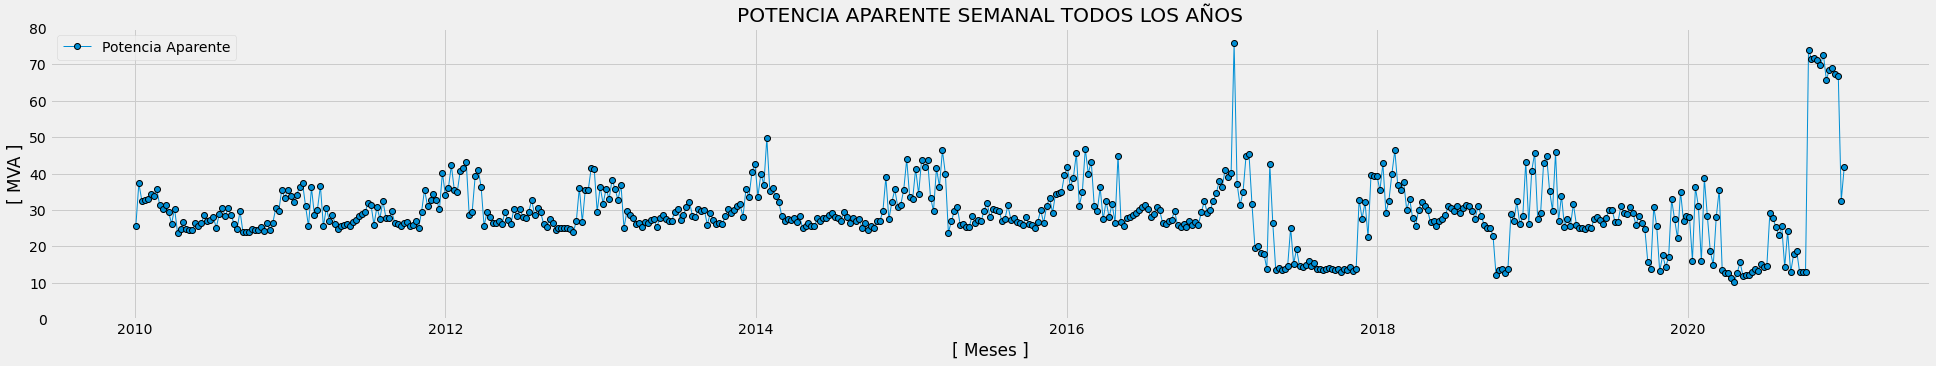

<Figure size 432x288 with 0 Axes>

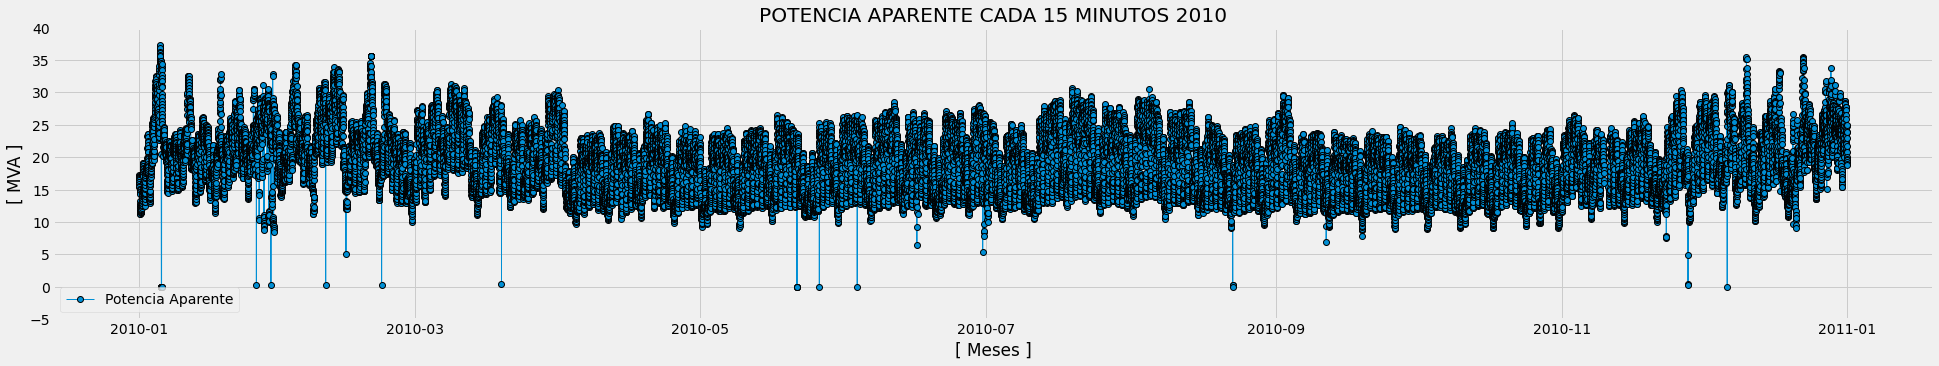

<Figure size 432x288 with 0 Axes>

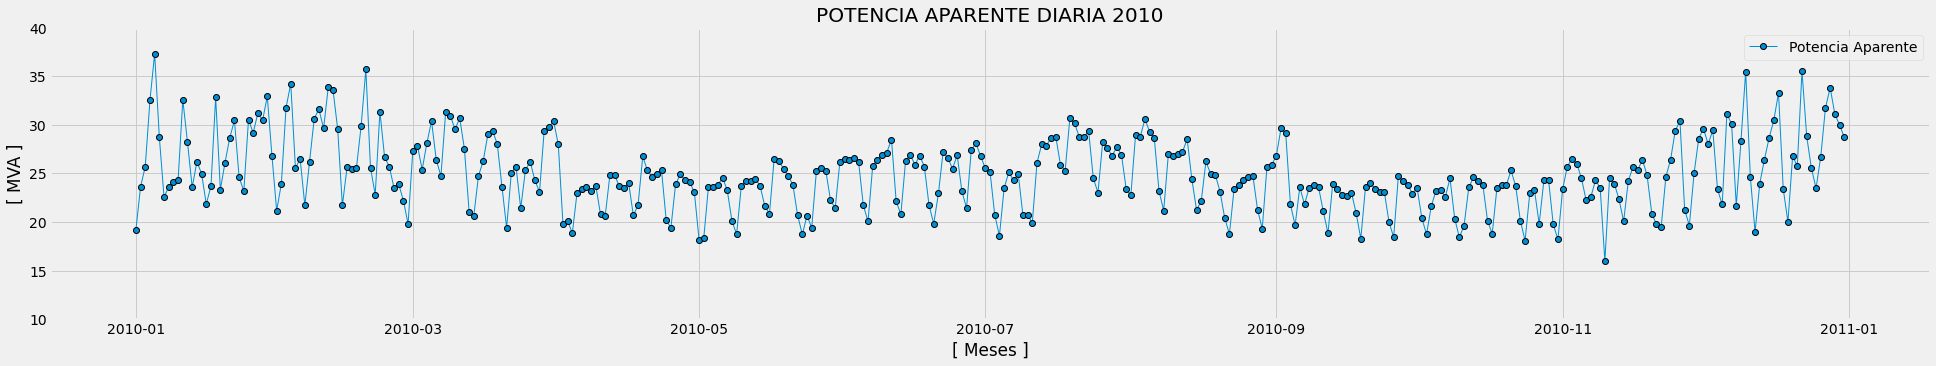

<Figure size 432x288 with 0 Axes>

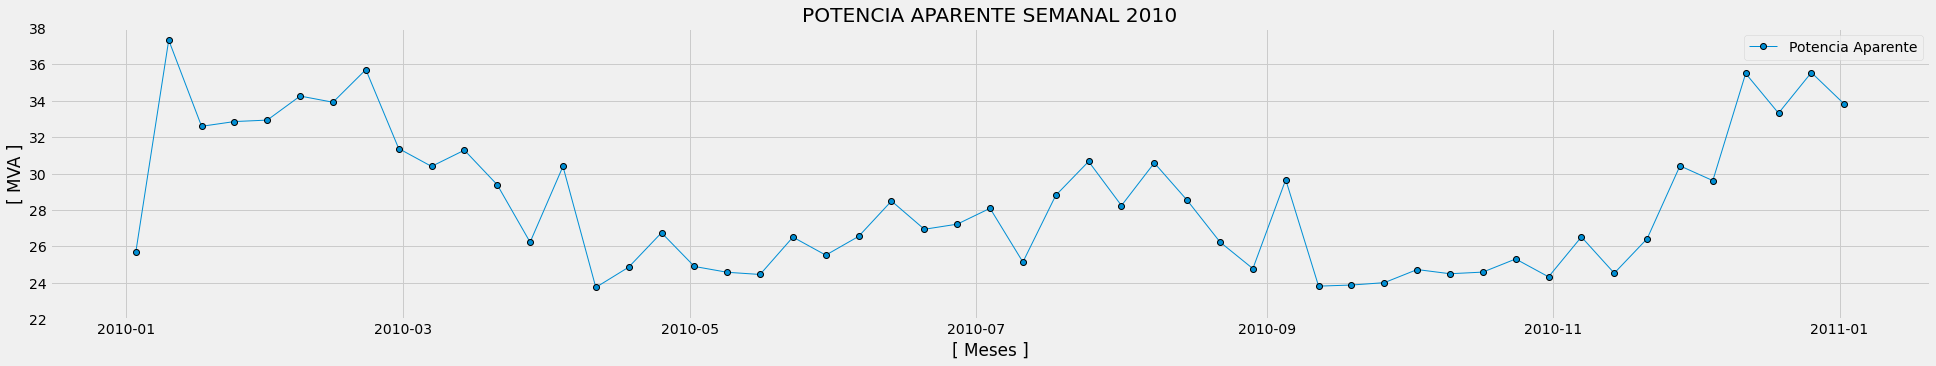

<Figure size 640x480 with 0 Axes>

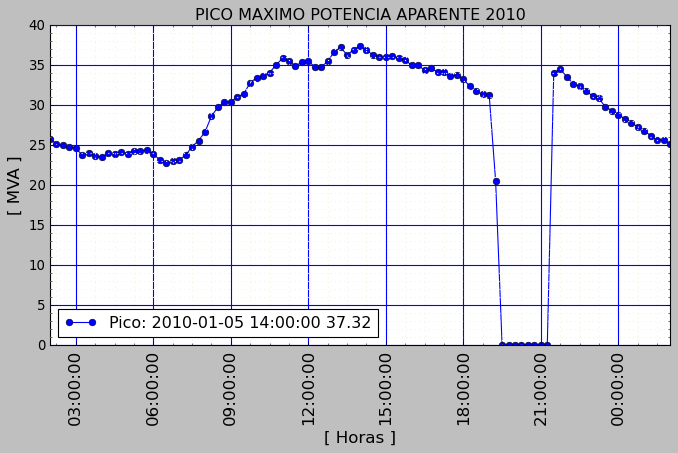

<Figure size 640x480 with 0 Axes>

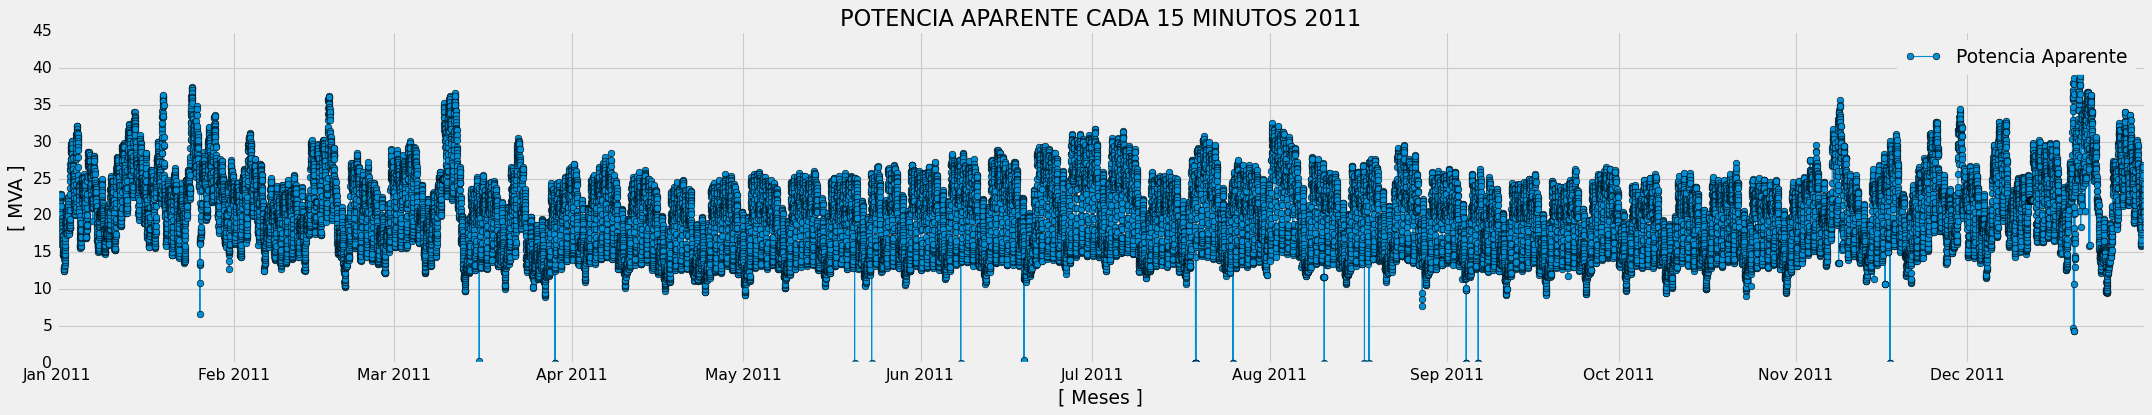

<Figure size 640x480 with 0 Axes>

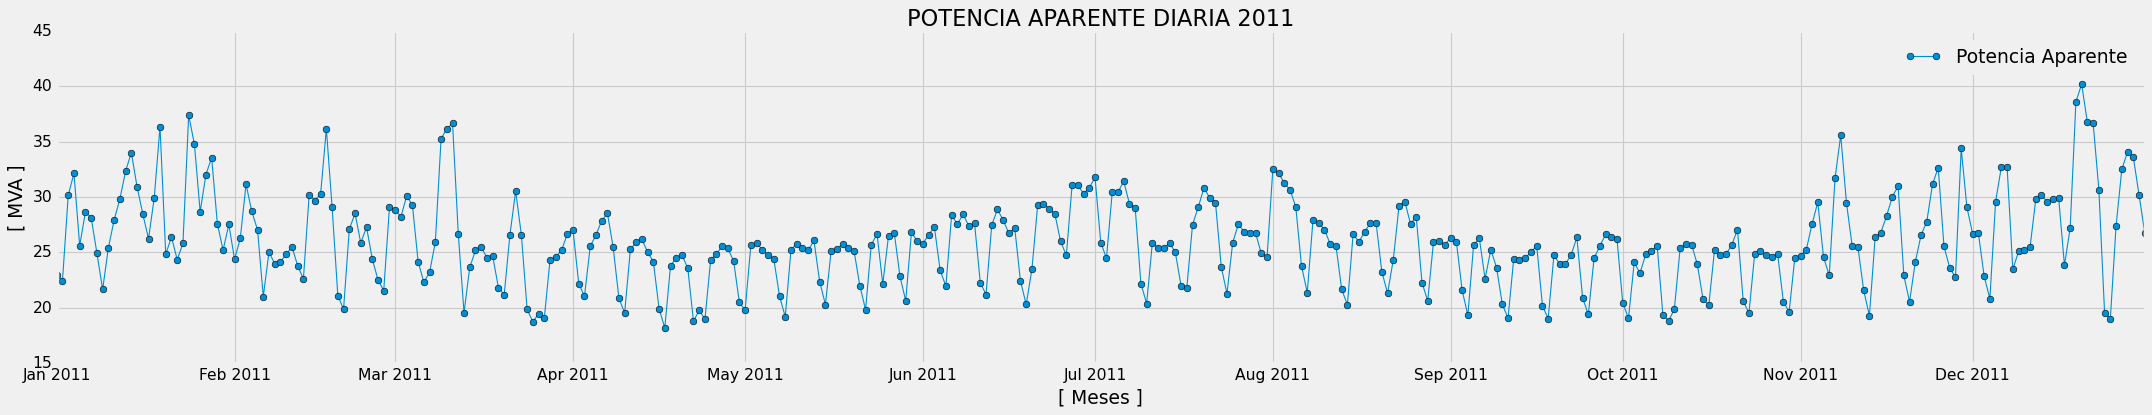

<Figure size 640x480 with 0 Axes>

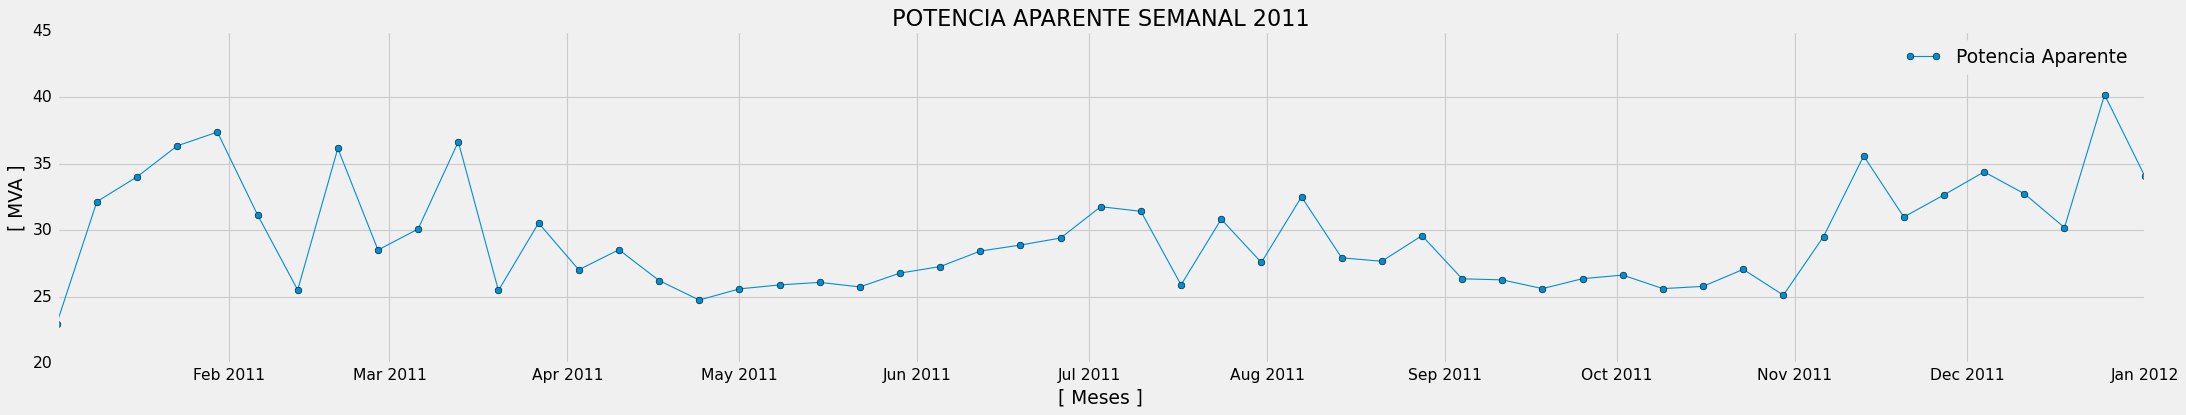

<Figure size 640x480 with 0 Axes>

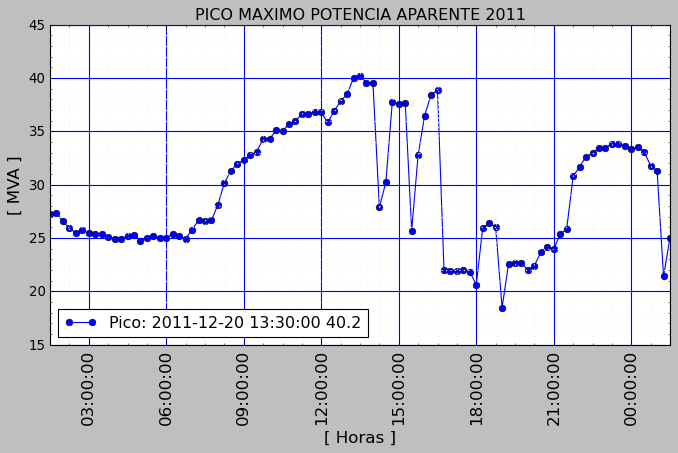

<Figure size 640x480 with 0 Axes>

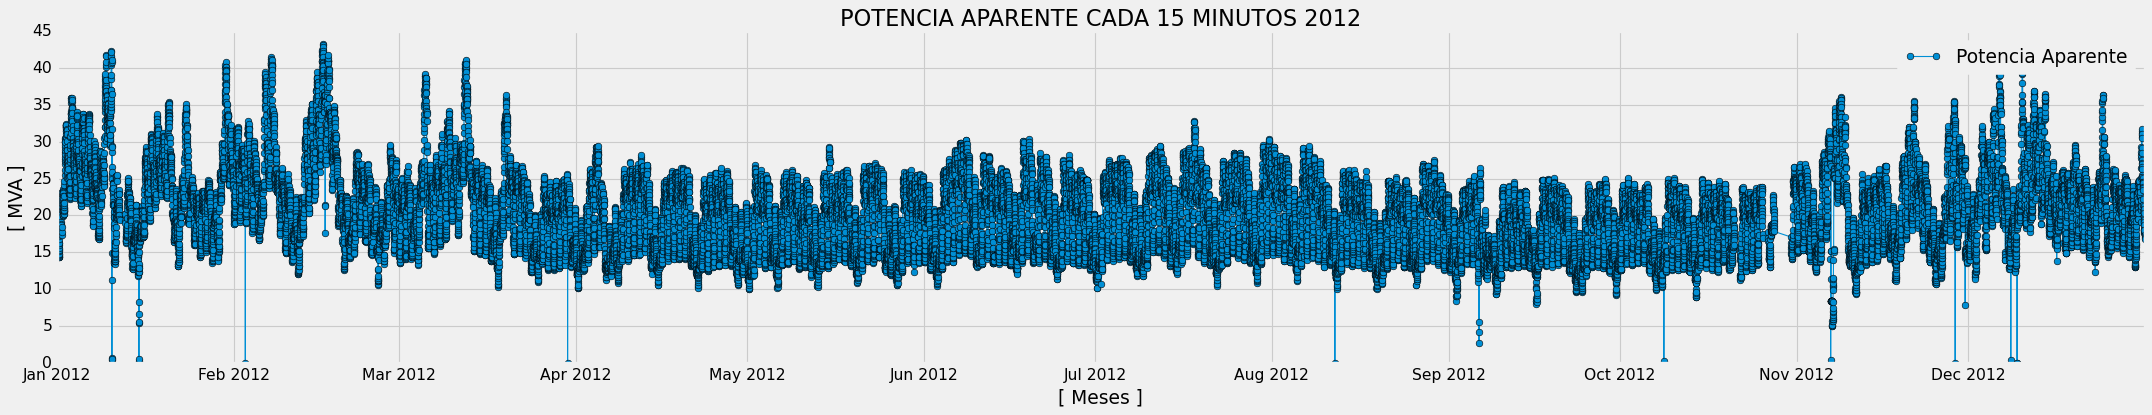

<Figure size 640x480 with 0 Axes>

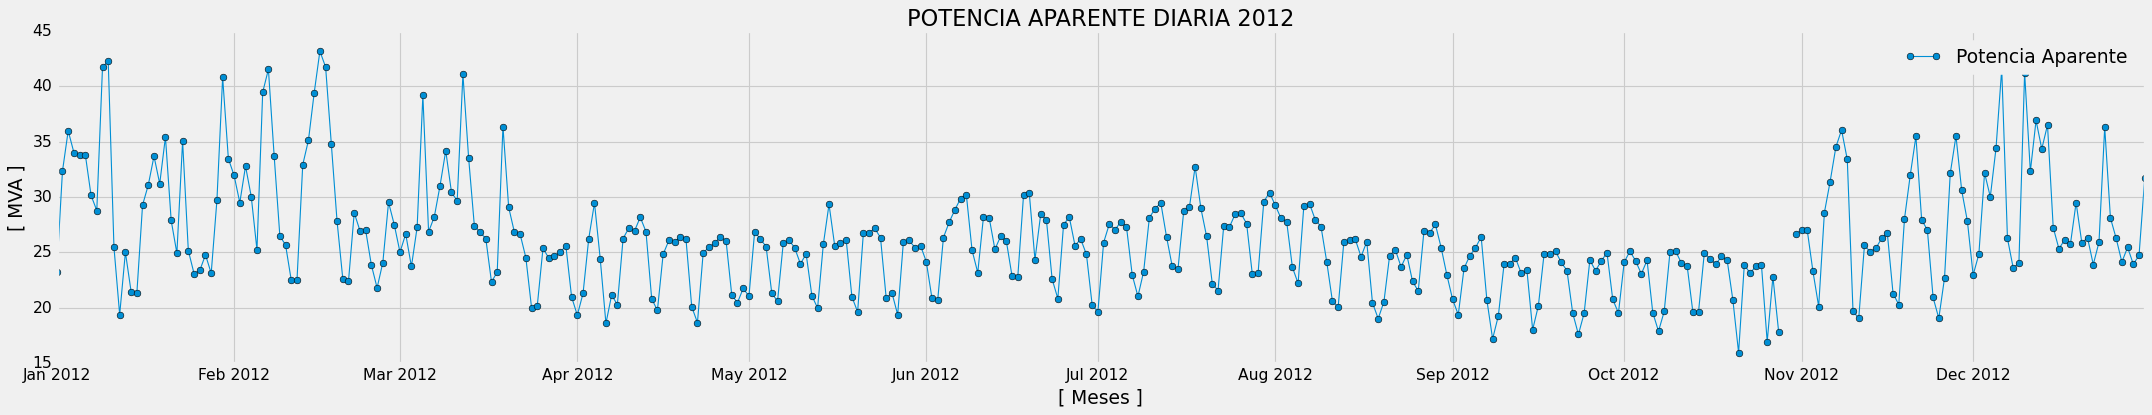

<Figure size 640x480 with 0 Axes>

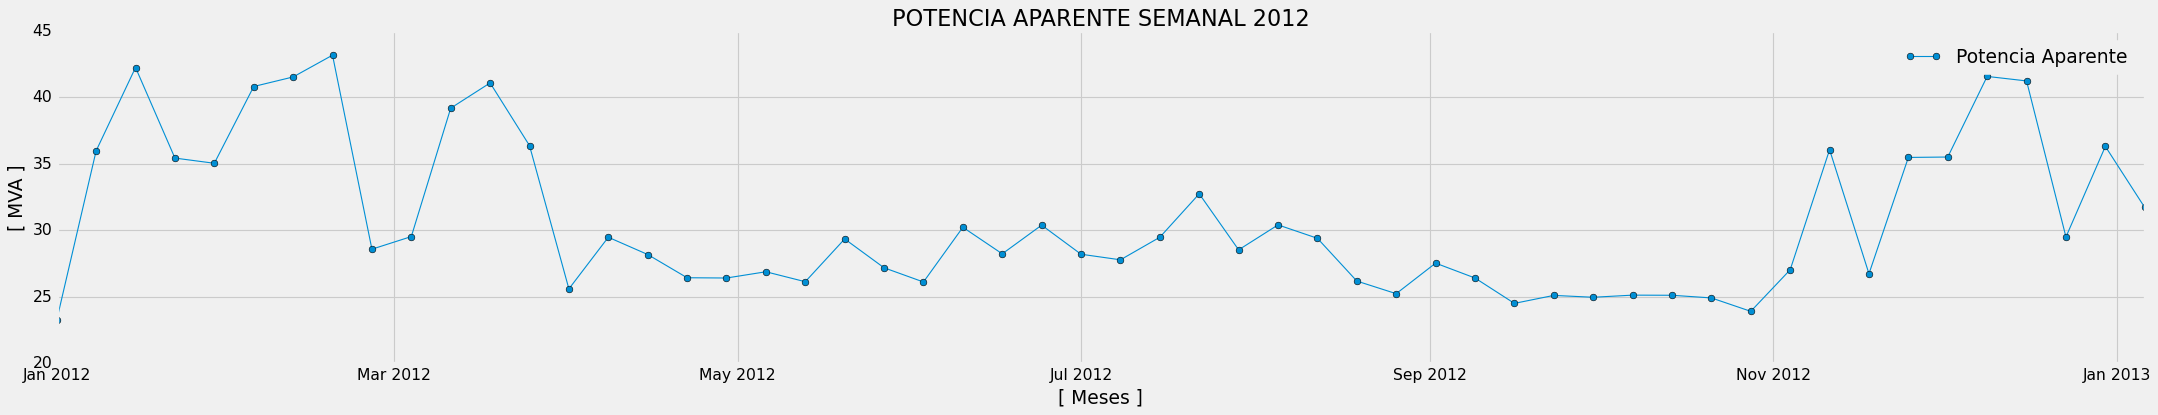

<Figure size 640x480 with 0 Axes>

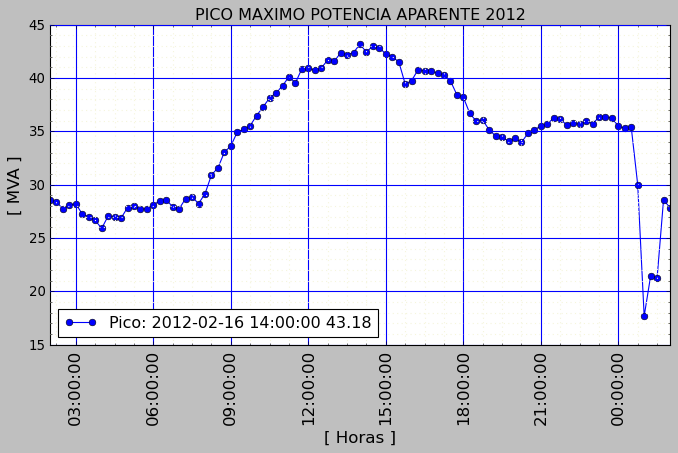

<Figure size 640x480 with 0 Axes>

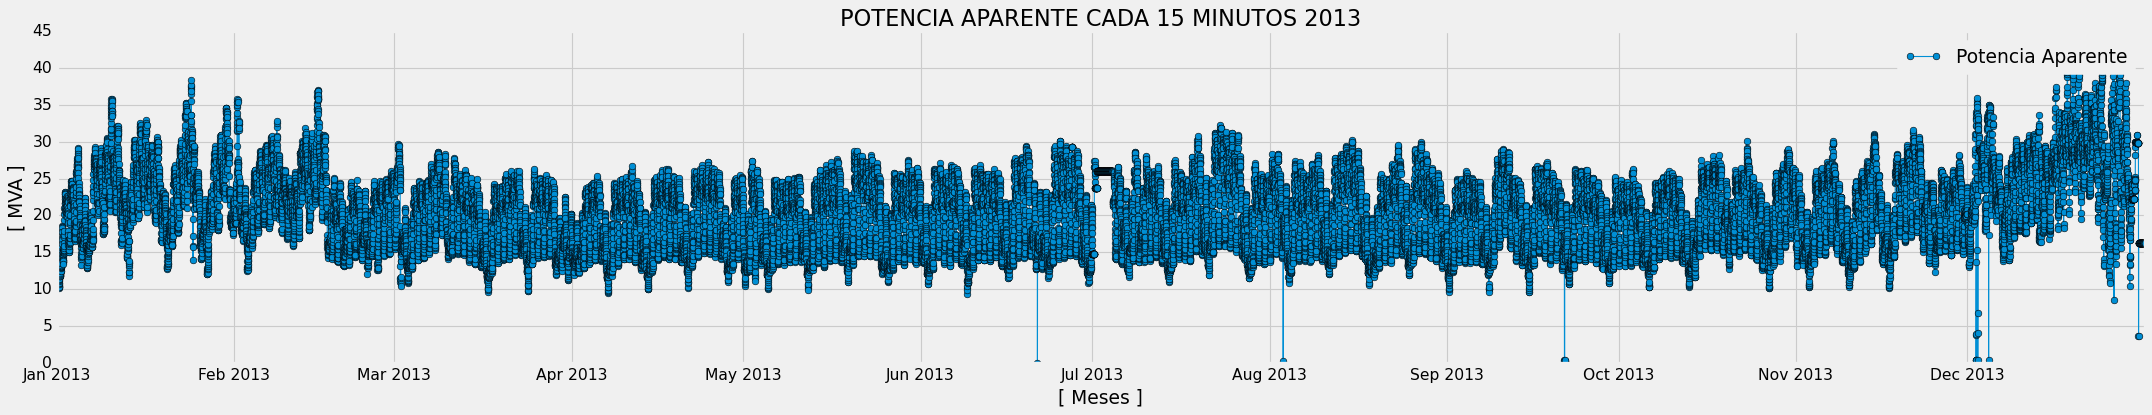

<Figure size 640x480 with 0 Axes>

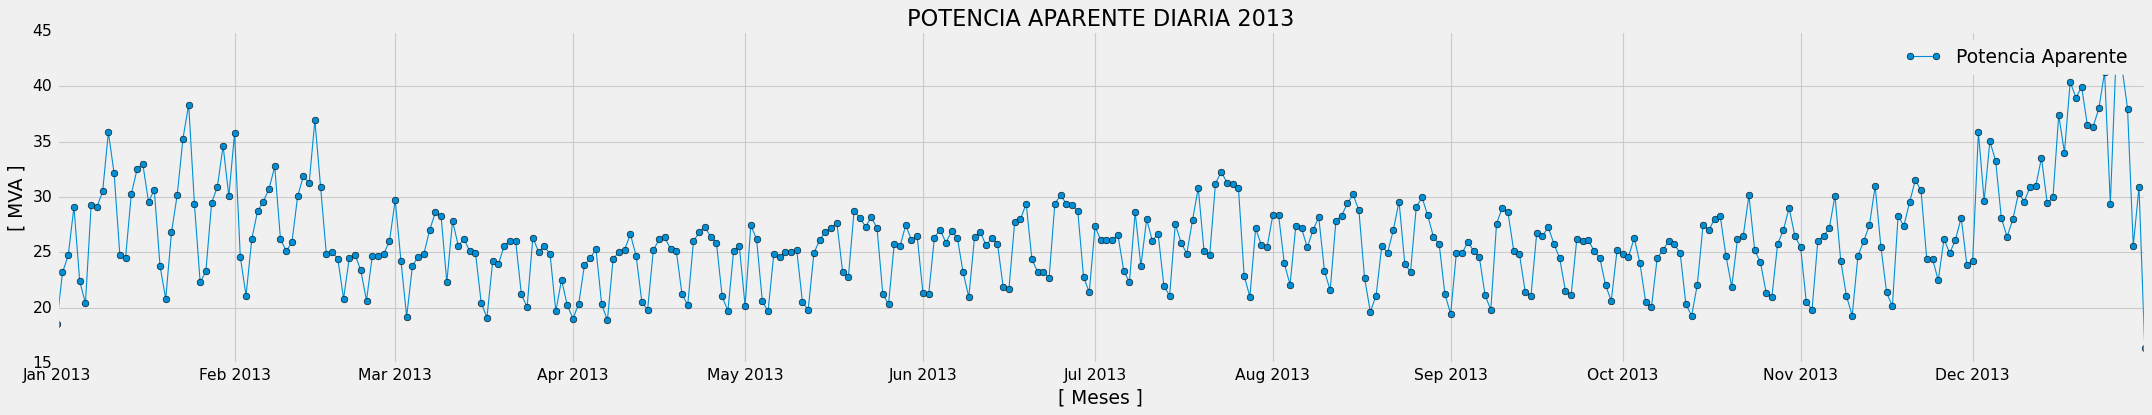

<Figure size 640x480 with 0 Axes>

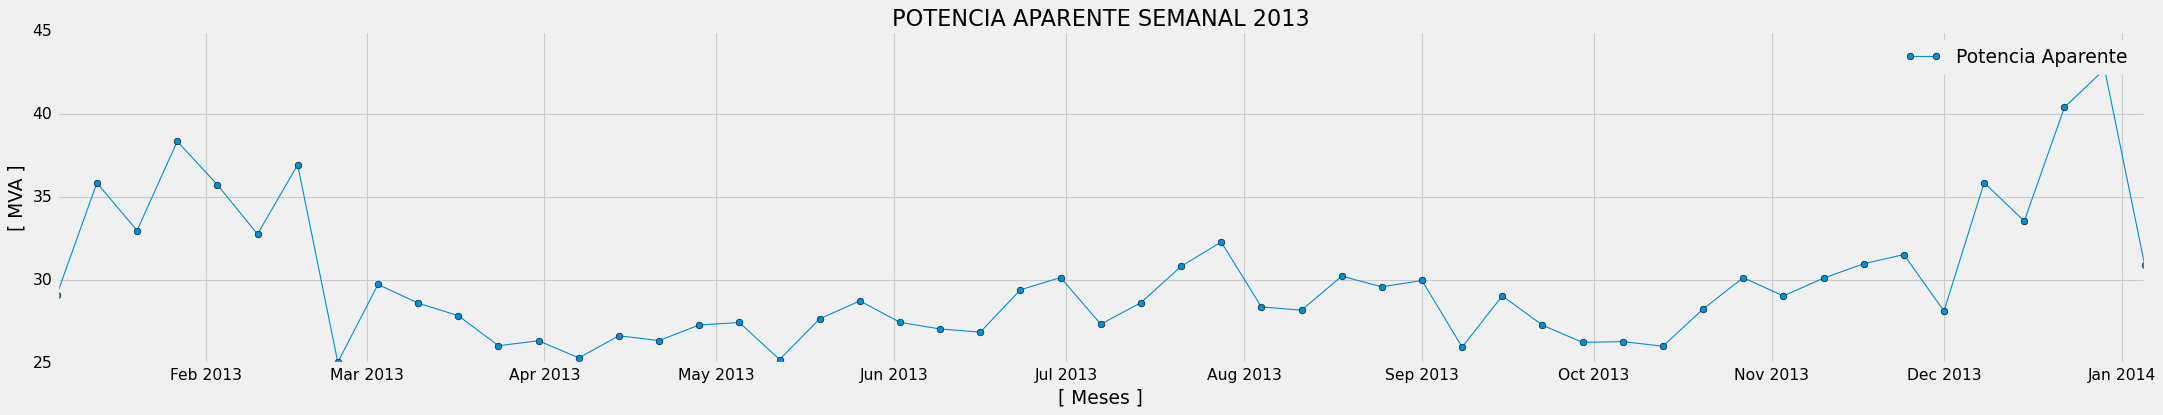

<Figure size 640x480 with 0 Axes>

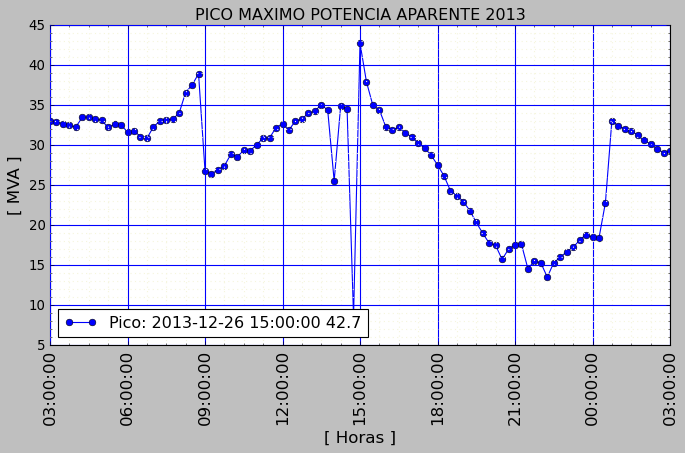

<Figure size 640x480 with 0 Axes>

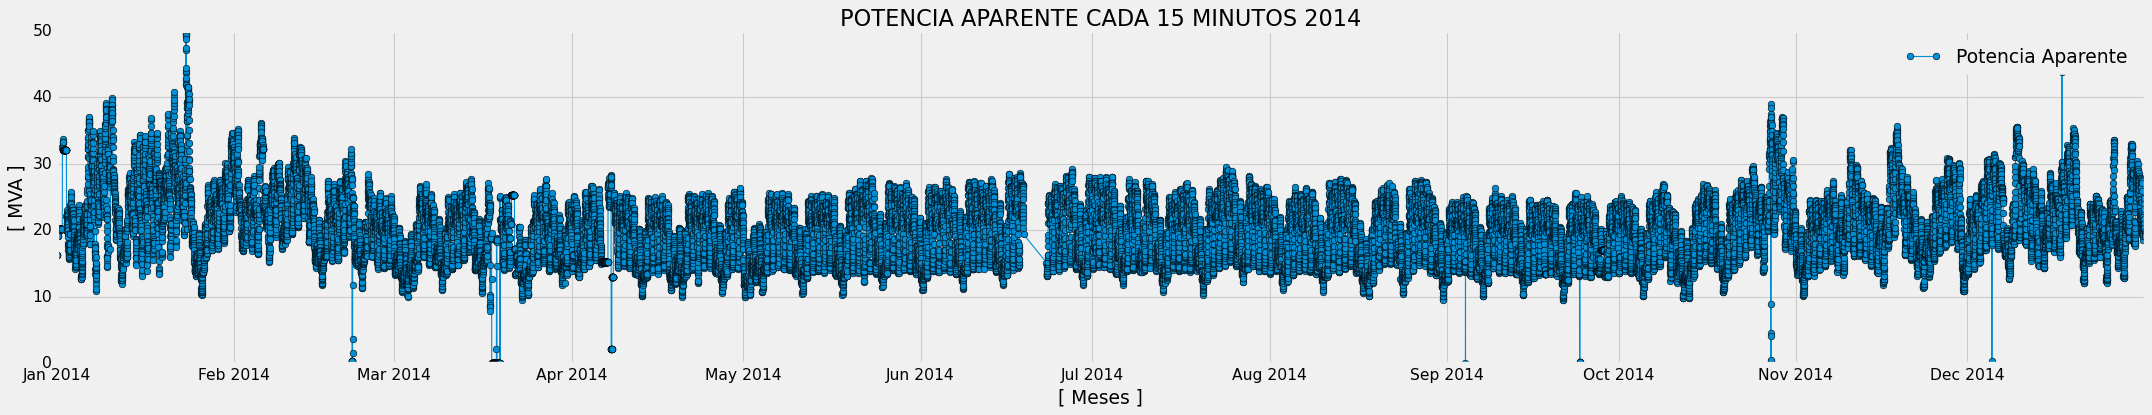

<Figure size 640x480 with 0 Axes>

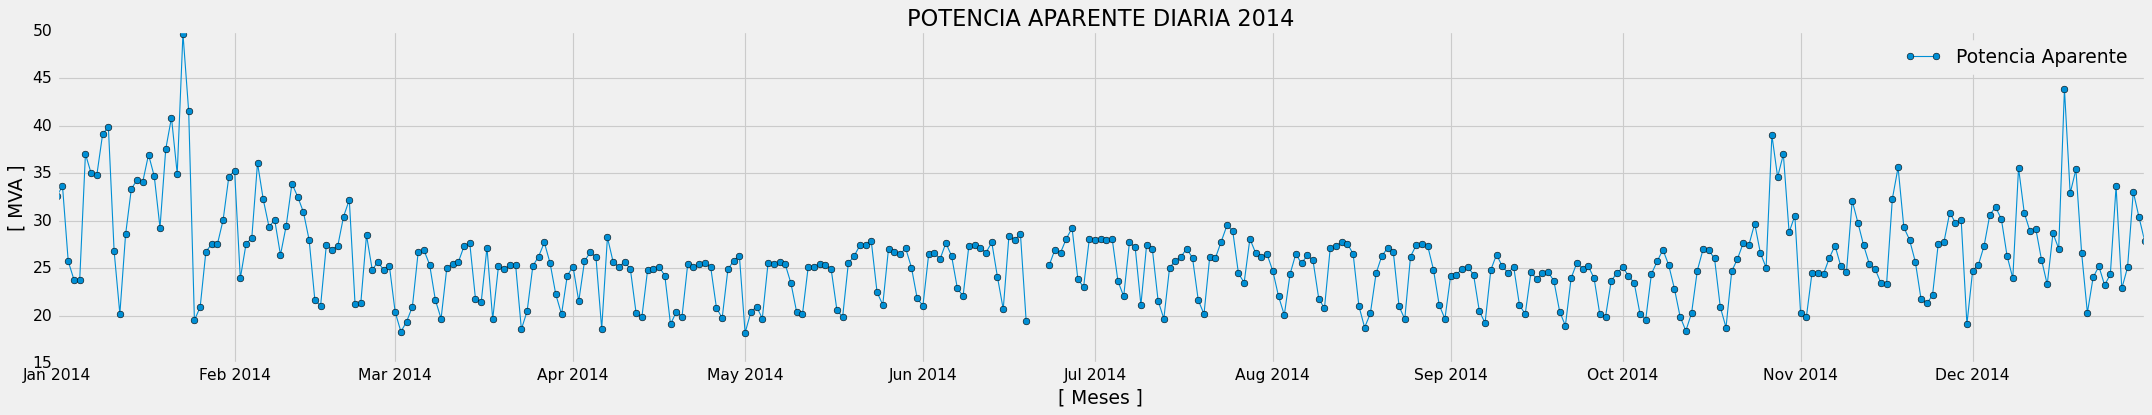

<Figure size 640x480 with 0 Axes>

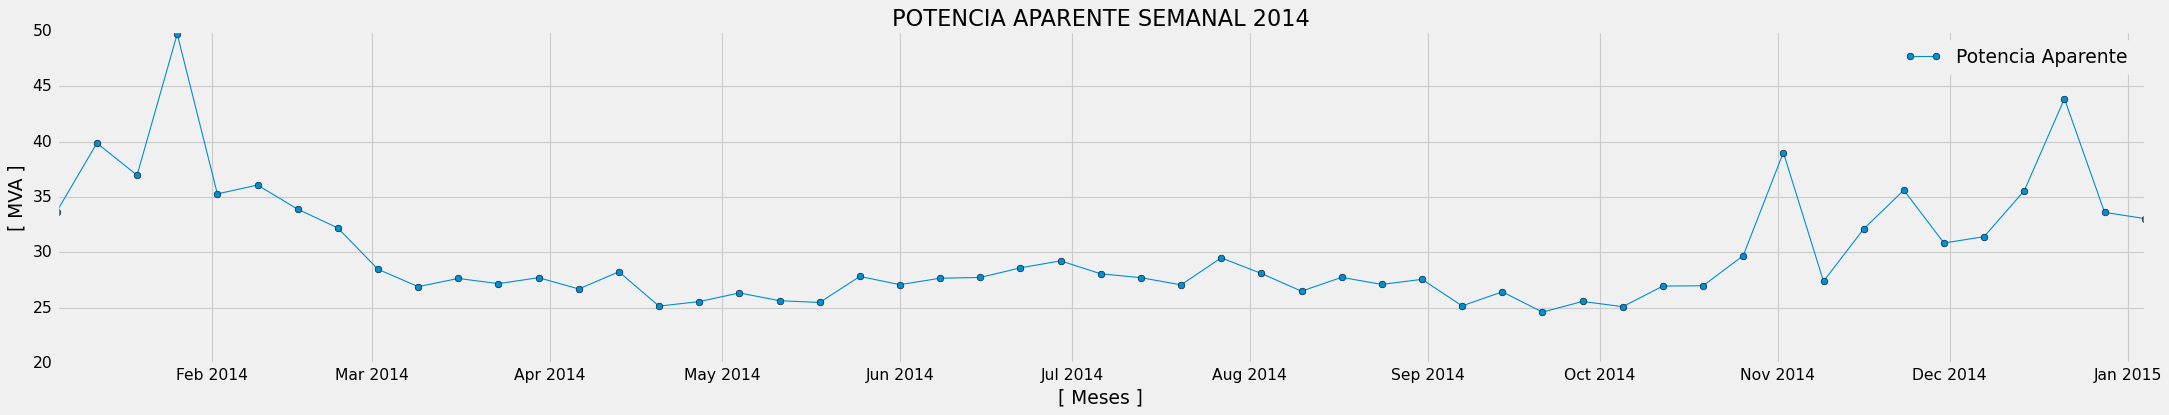

<Figure size 640x480 with 0 Axes>

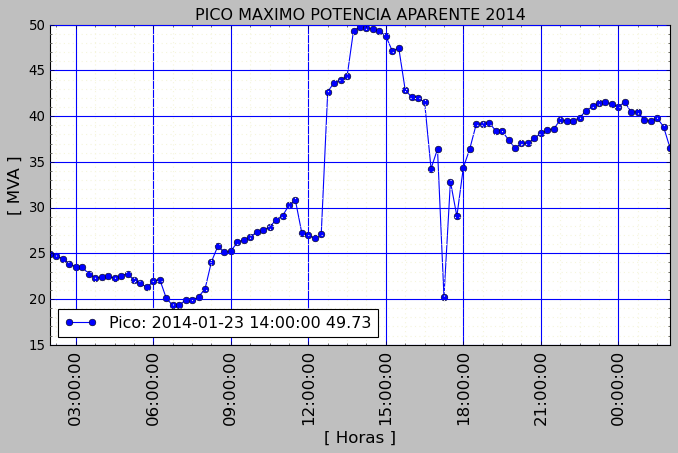

<Figure size 640x480 with 0 Axes>

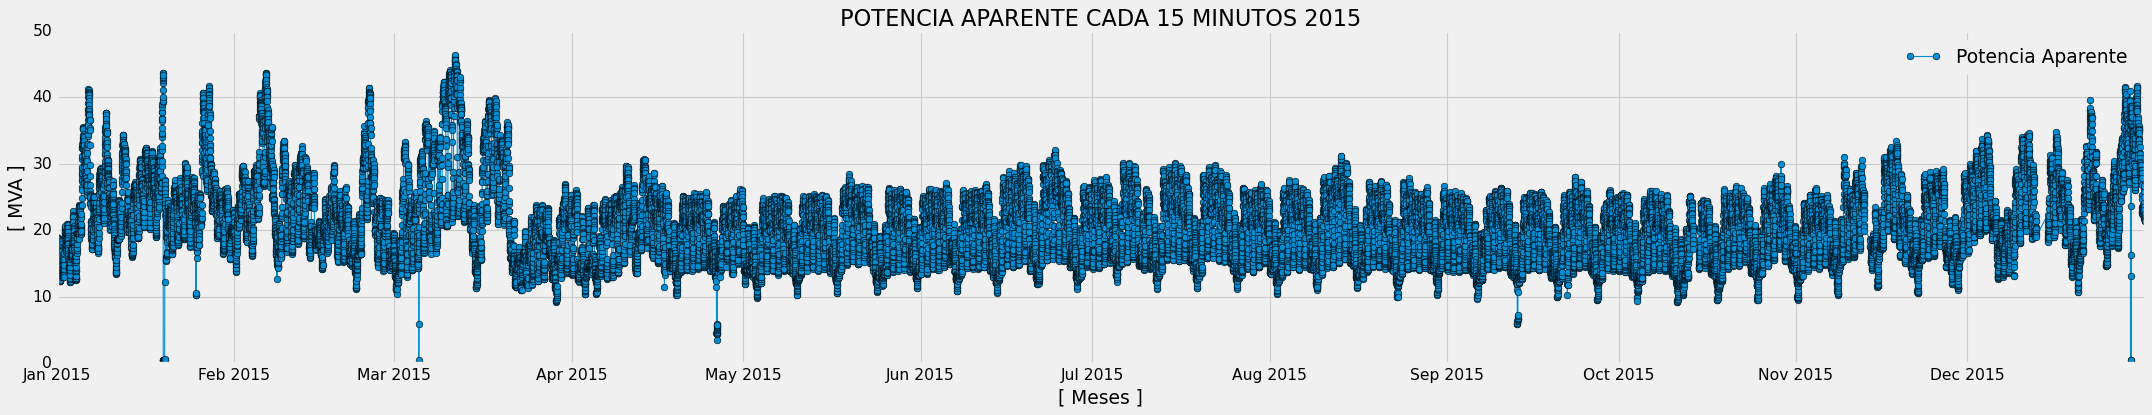

<Figure size 640x480 with 0 Axes>

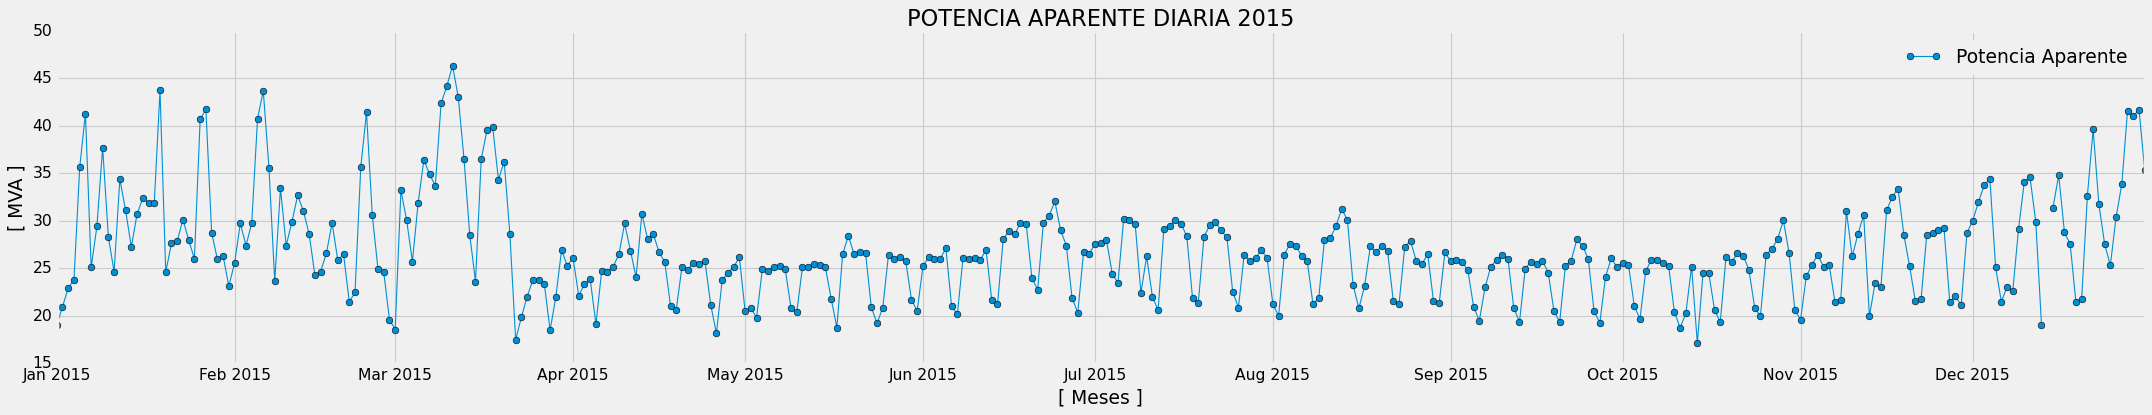

<Figure size 640x480 with 0 Axes>

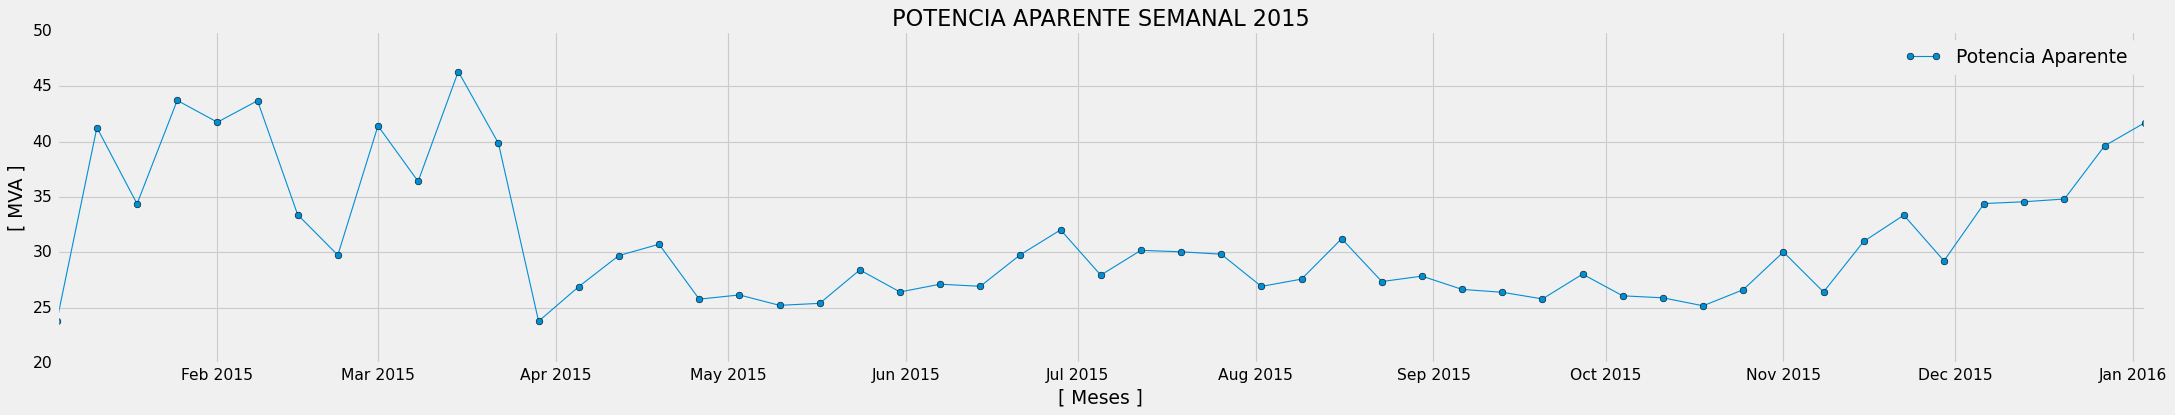

<Figure size 640x480 with 0 Axes>

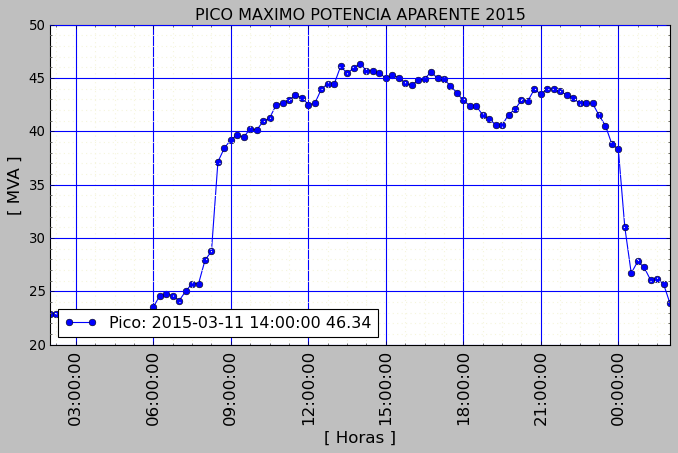

<Figure size 640x480 with 0 Axes>

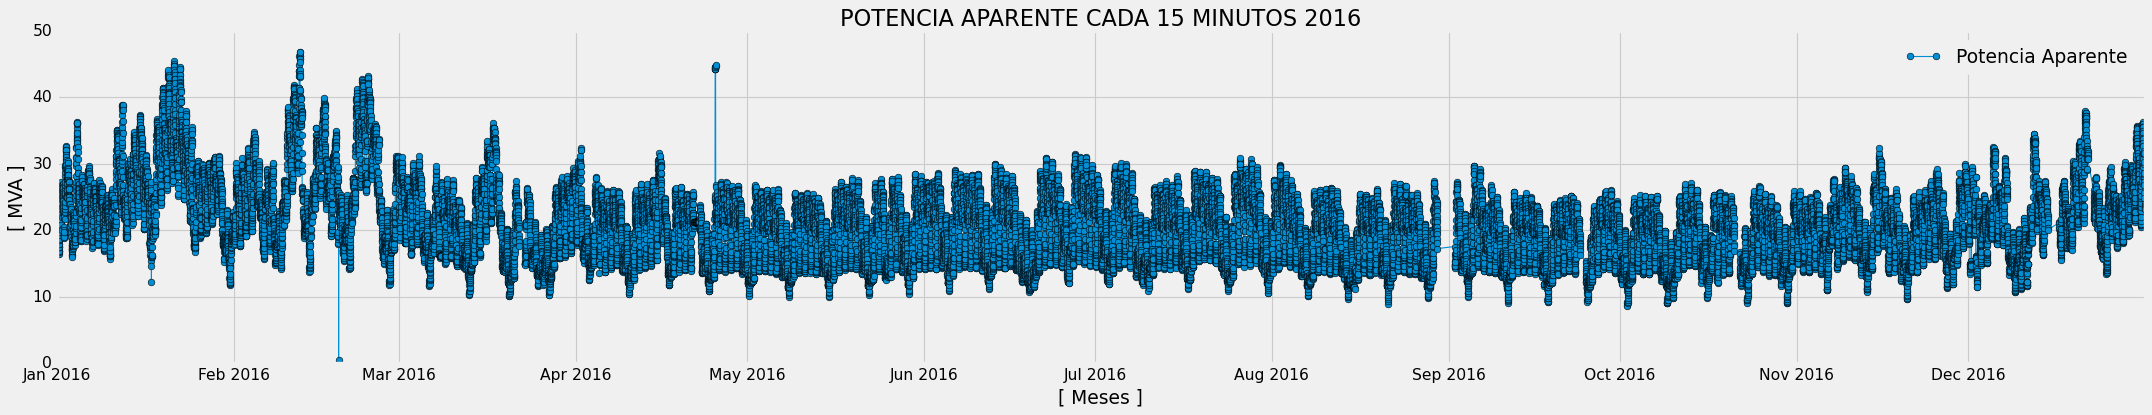

<Figure size 640x480 with 0 Axes>

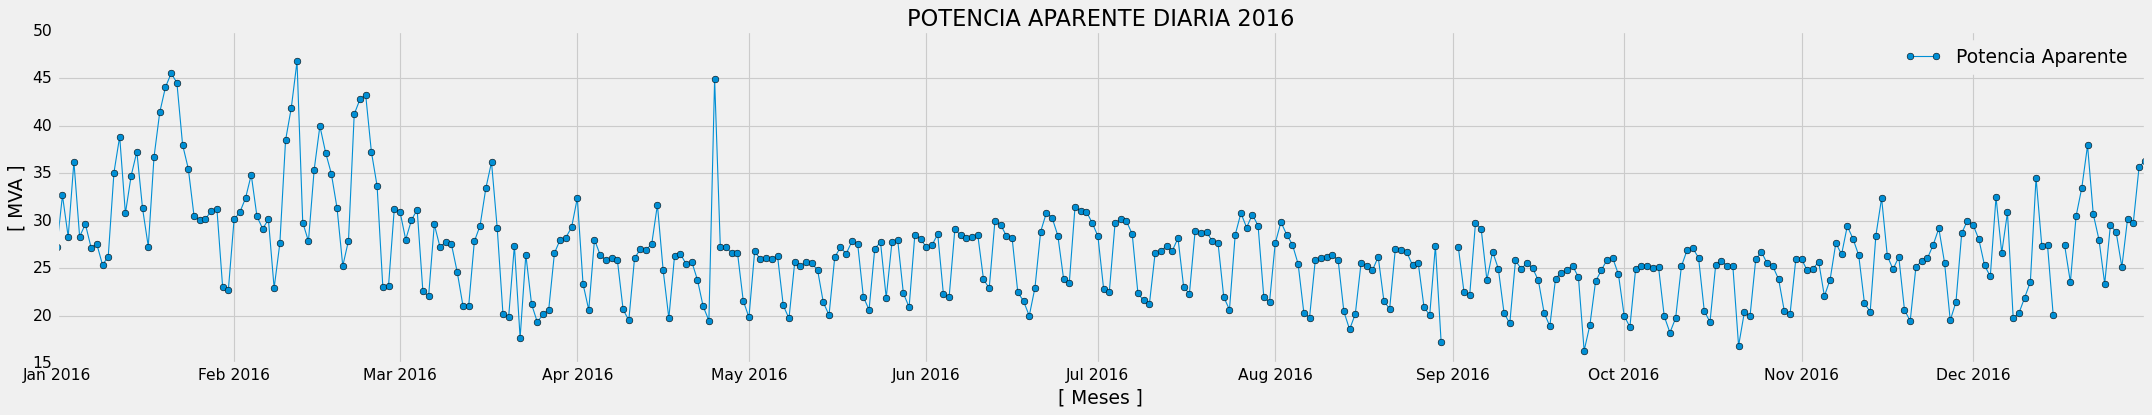

<Figure size 640x480 with 0 Axes>

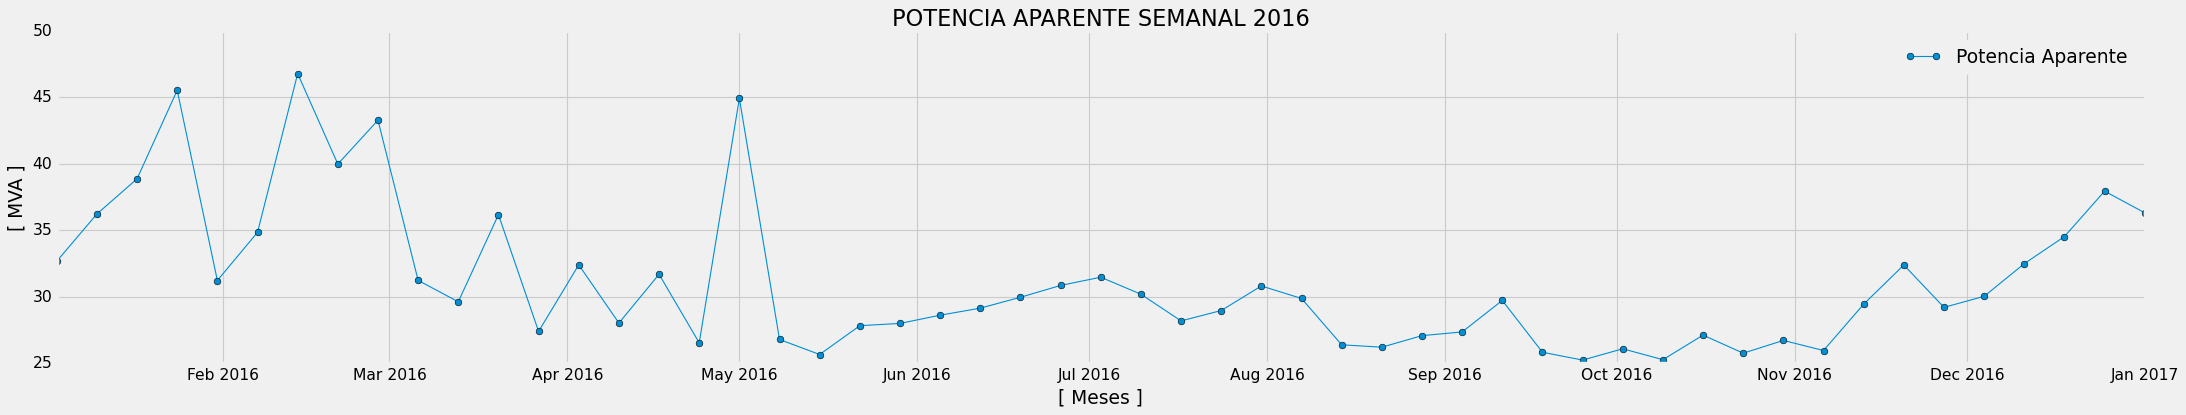

<Figure size 640x480 with 0 Axes>

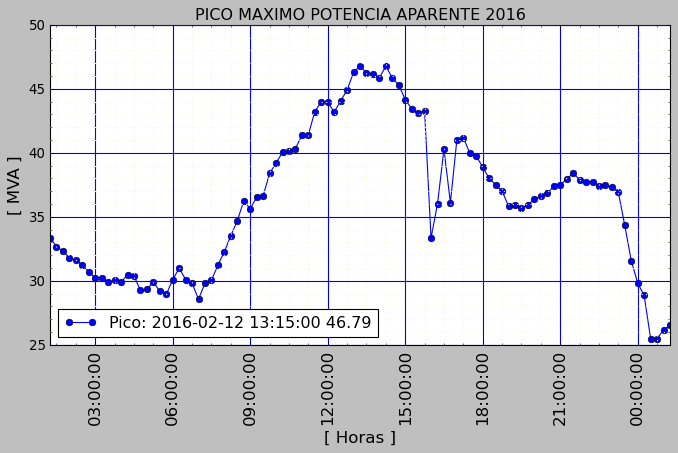

<Figure size 640x480 with 0 Axes>

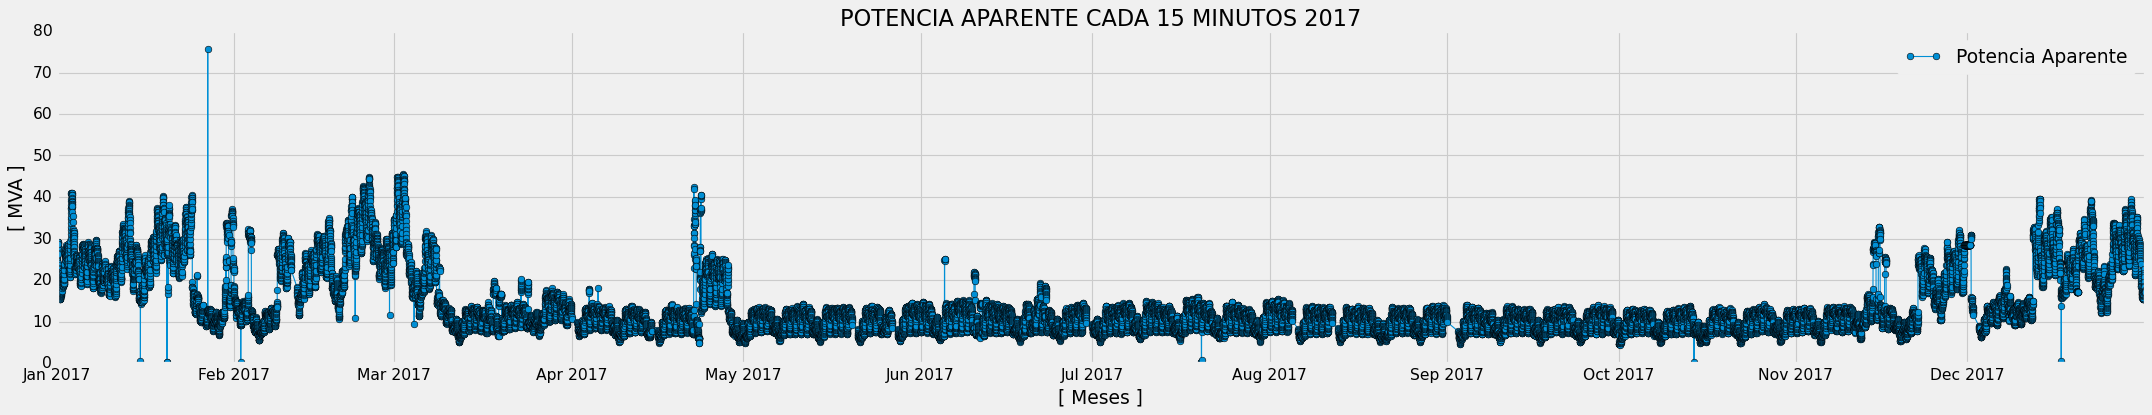

<Figure size 640x480 with 0 Axes>

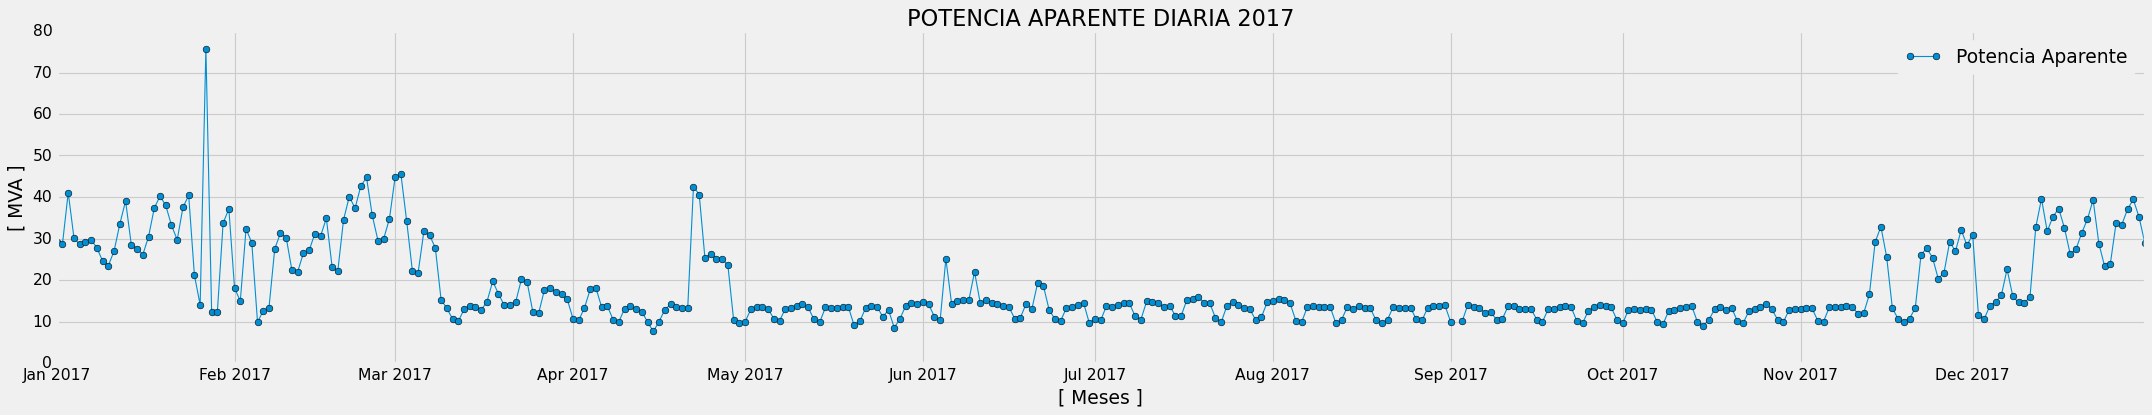

<Figure size 640x480 with 0 Axes>

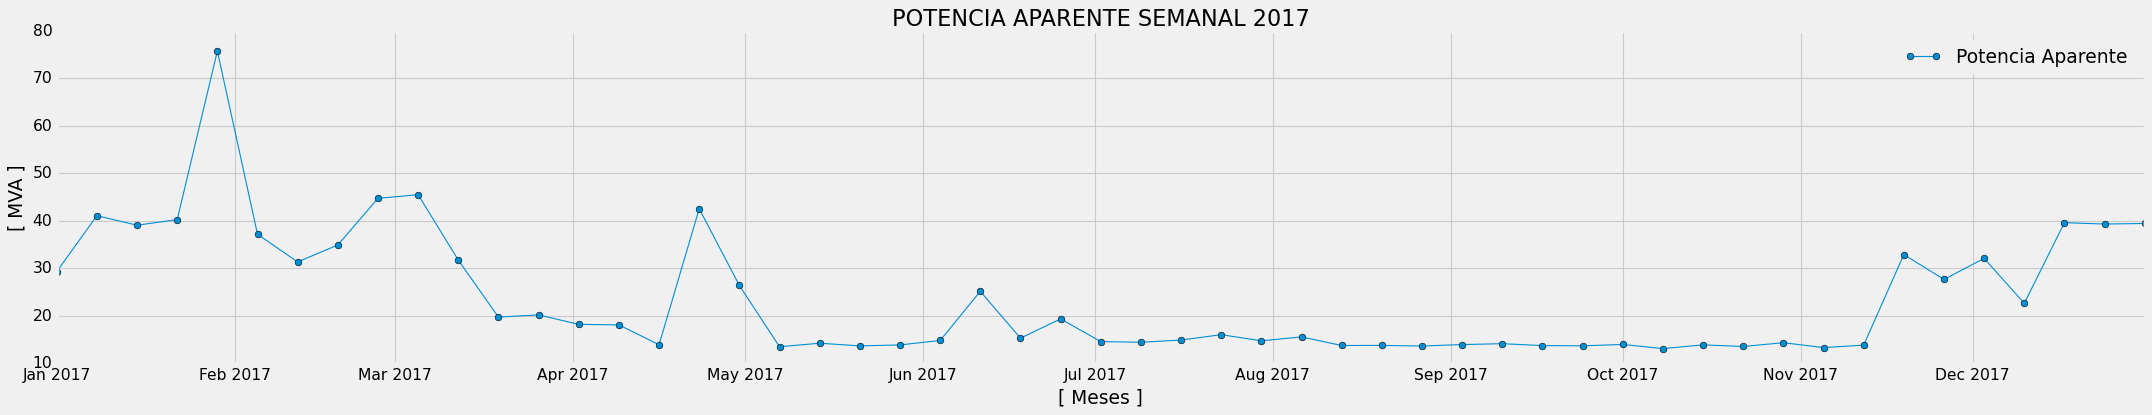

<Figure size 640x480 with 0 Axes>

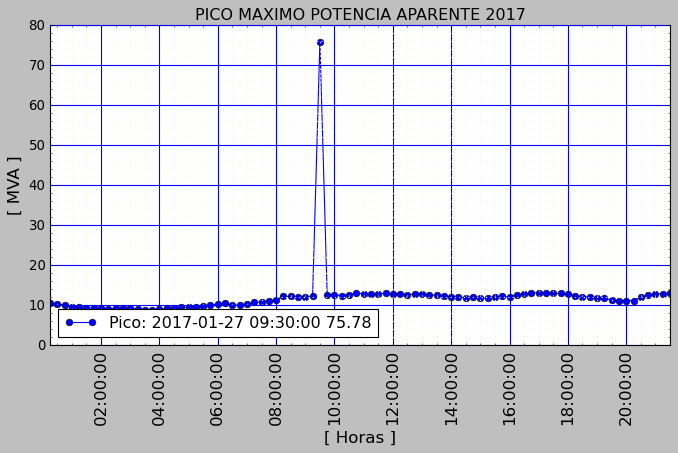

<Figure size 640x480 with 0 Axes>

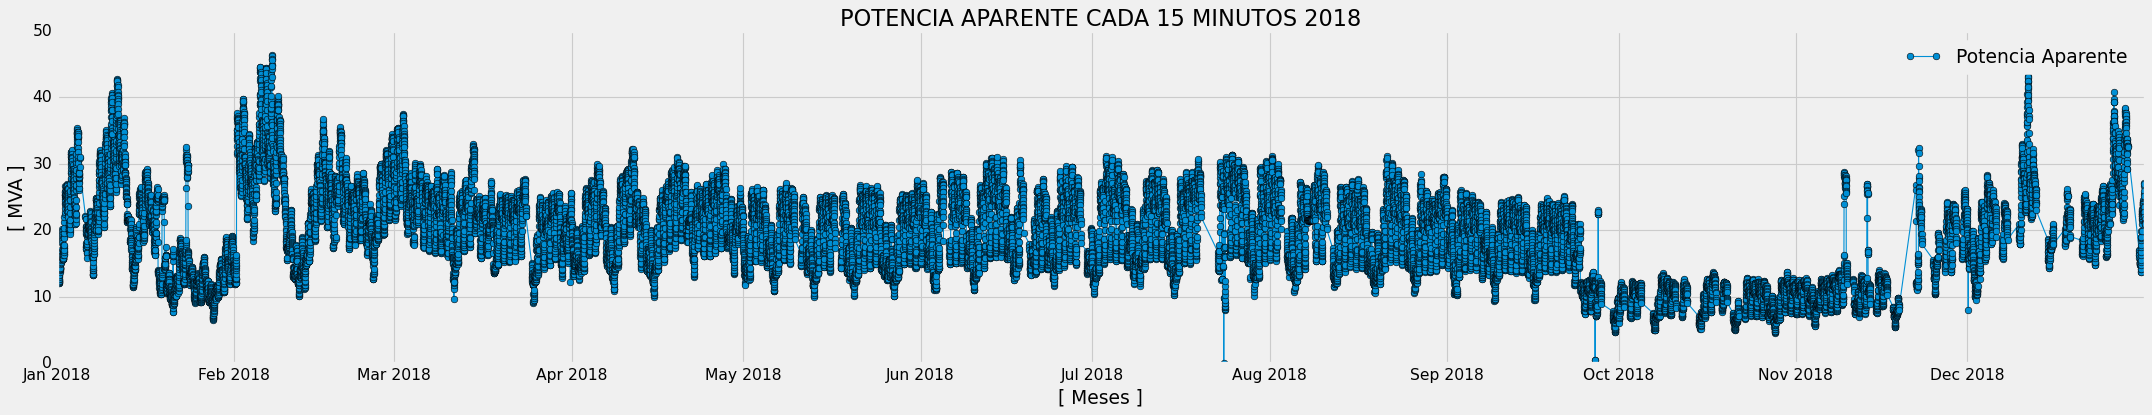

<Figure size 640x480 with 0 Axes>

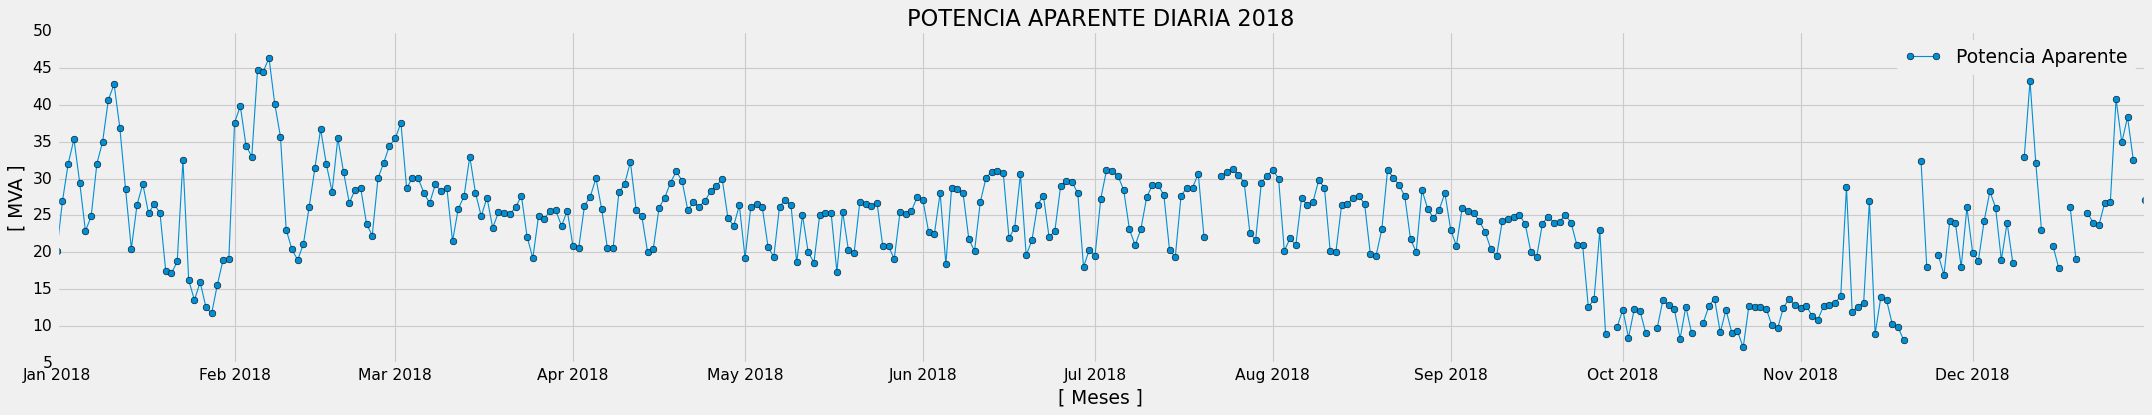

<Figure size 640x480 with 0 Axes>

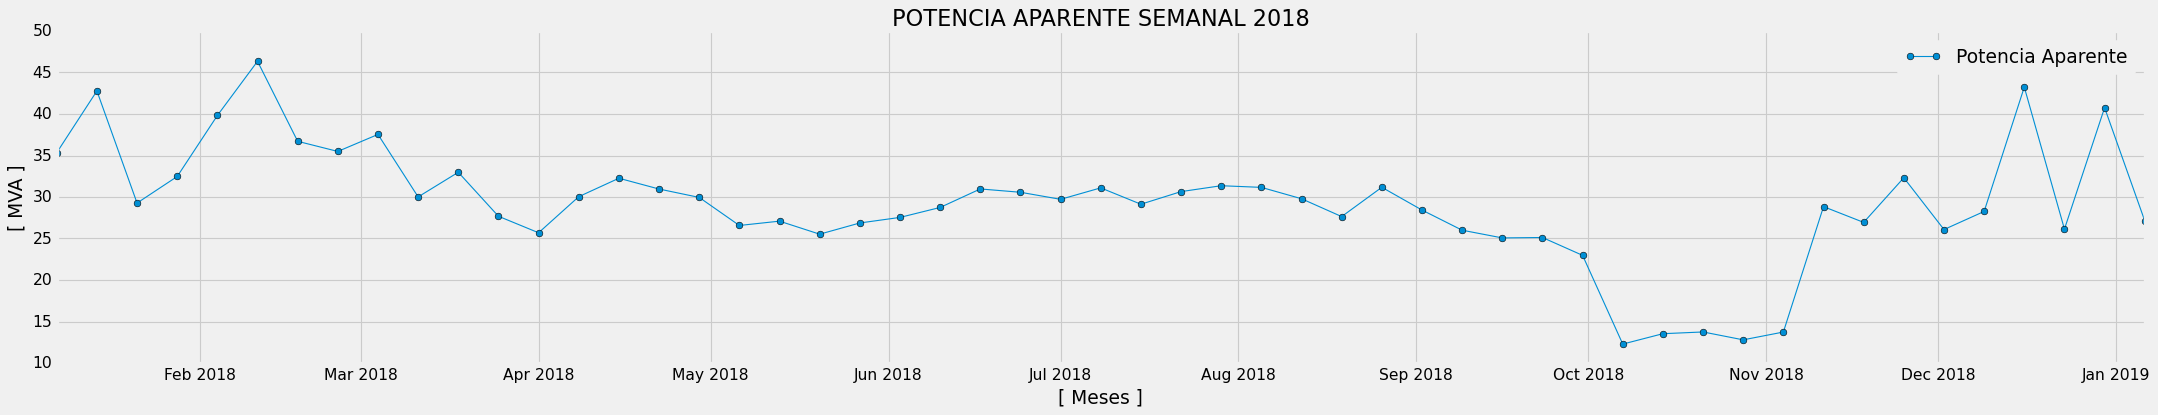

<Figure size 640x480 with 0 Axes>

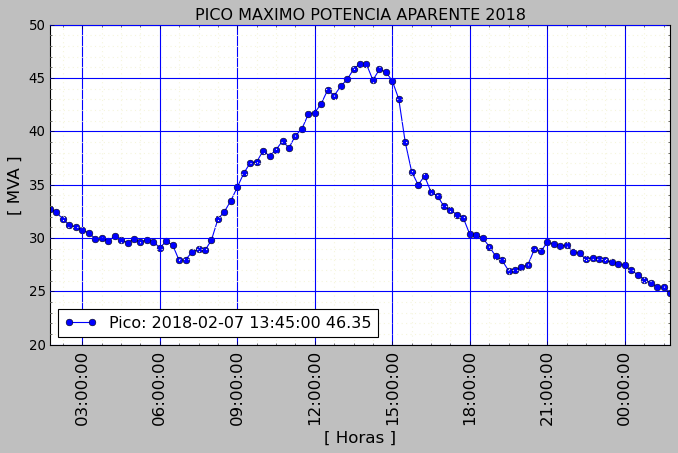

<Figure size 640x480 with 0 Axes>

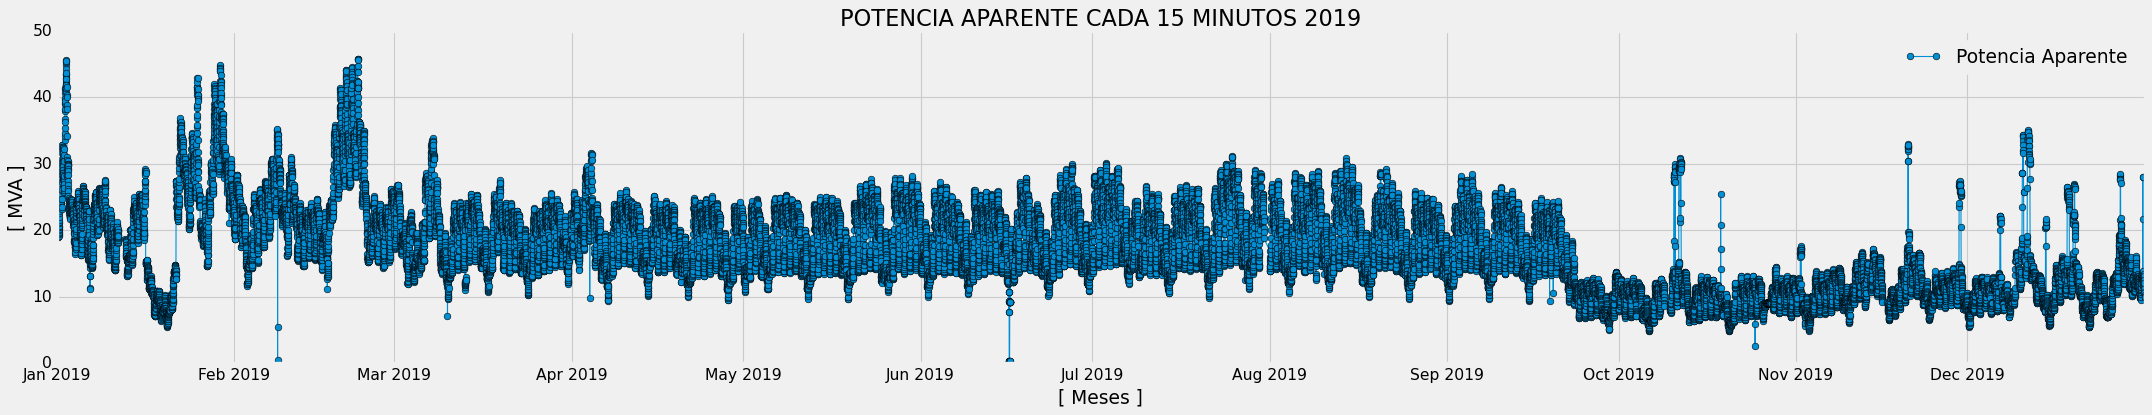

<Figure size 640x480 with 0 Axes>

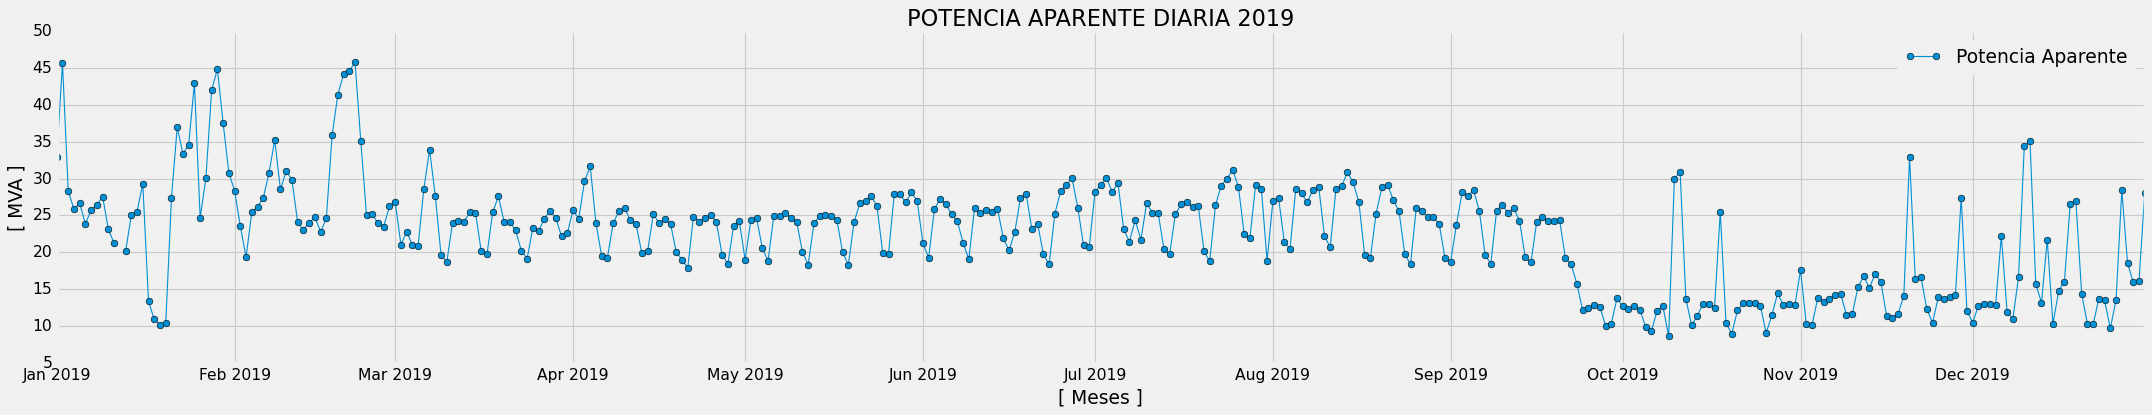

<Figure size 640x480 with 0 Axes>

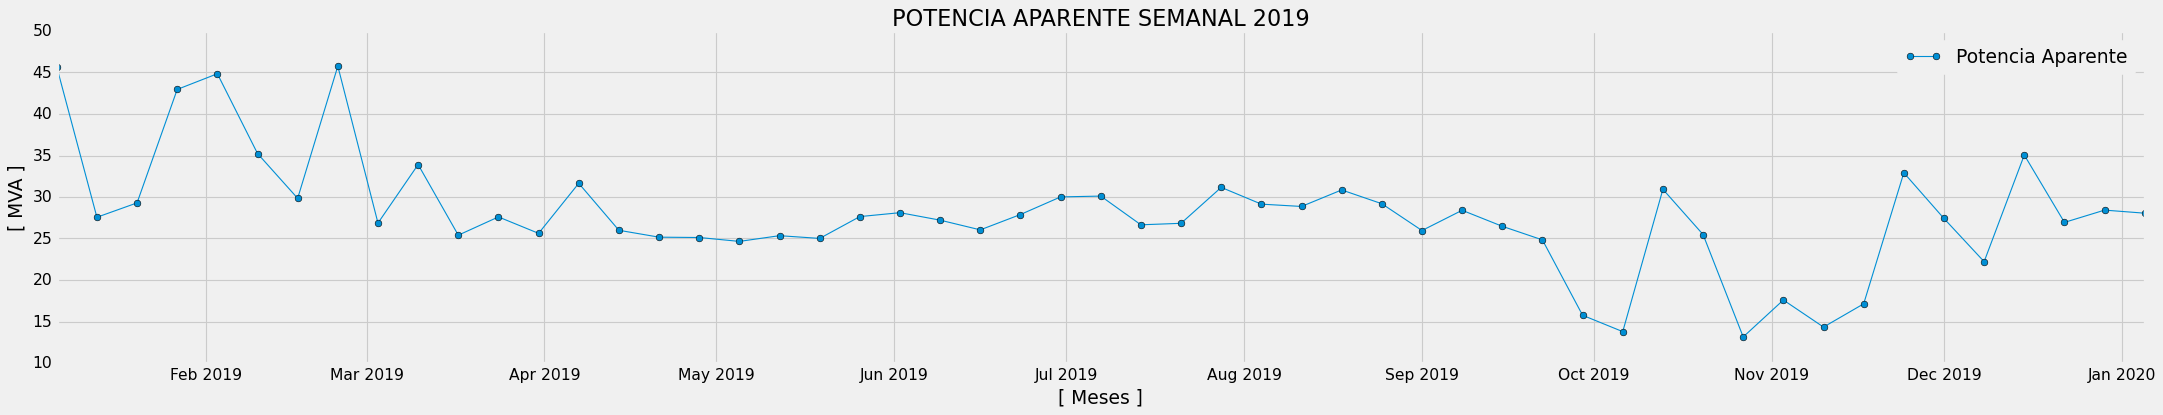

<Figure size 640x480 with 0 Axes>

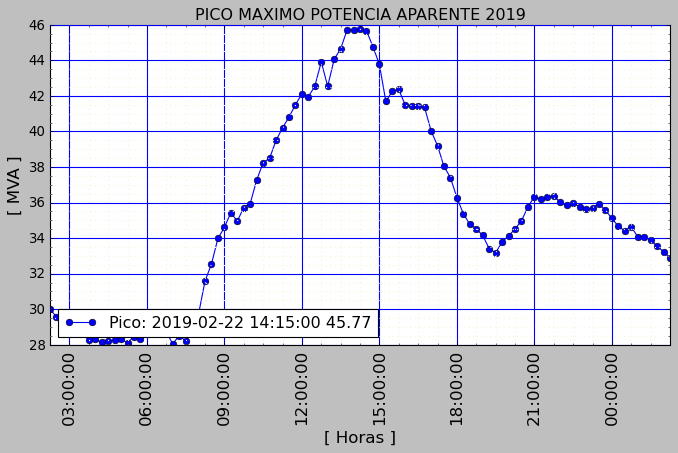

<Figure size 640x480 with 0 Axes>

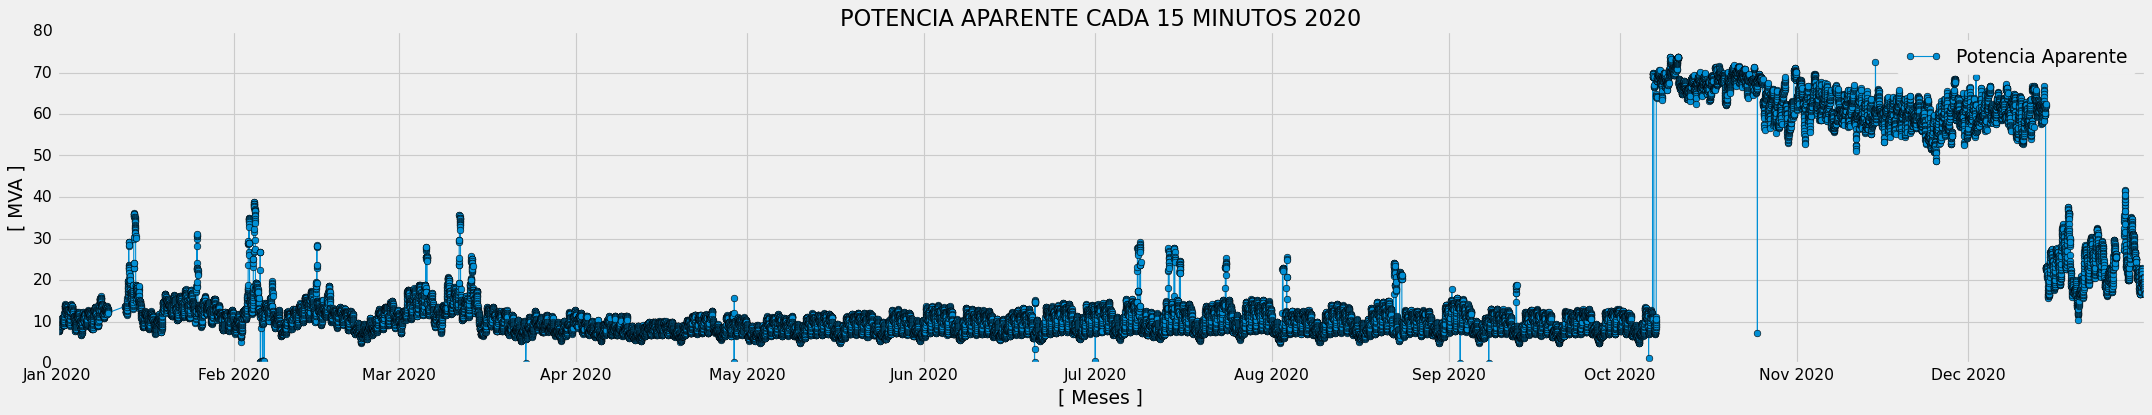

<Figure size 640x480 with 0 Axes>

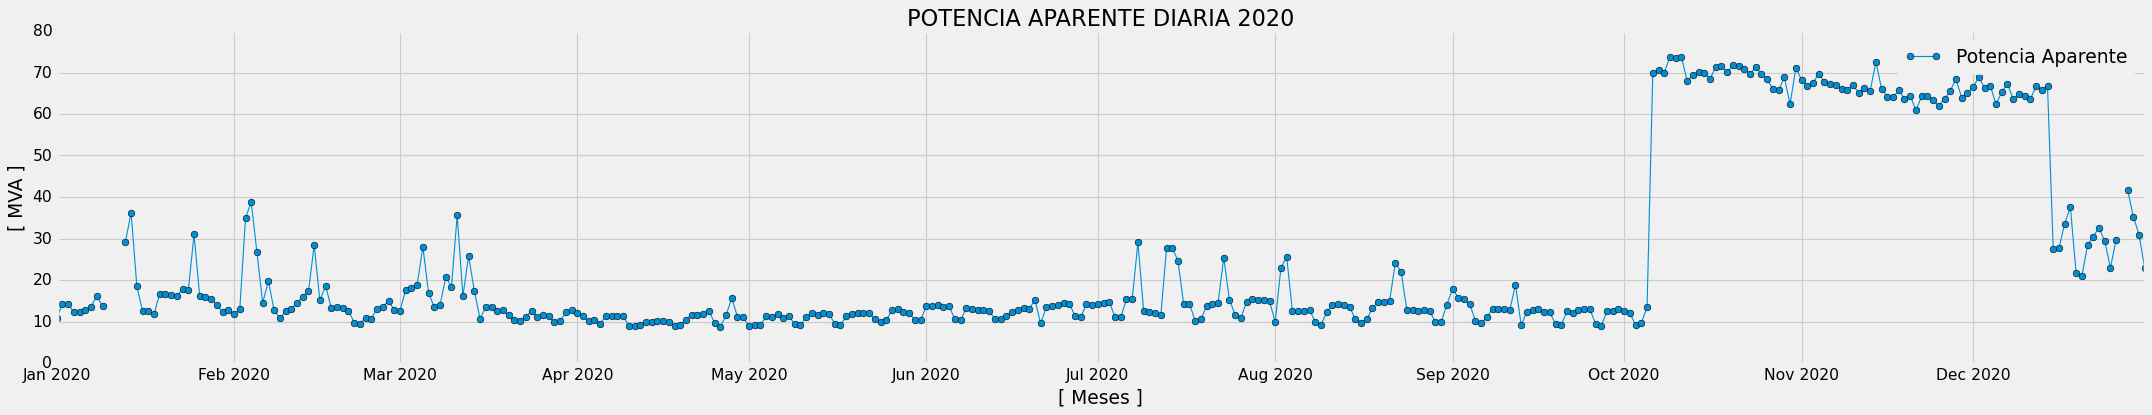

<Figure size 640x480 with 0 Axes>

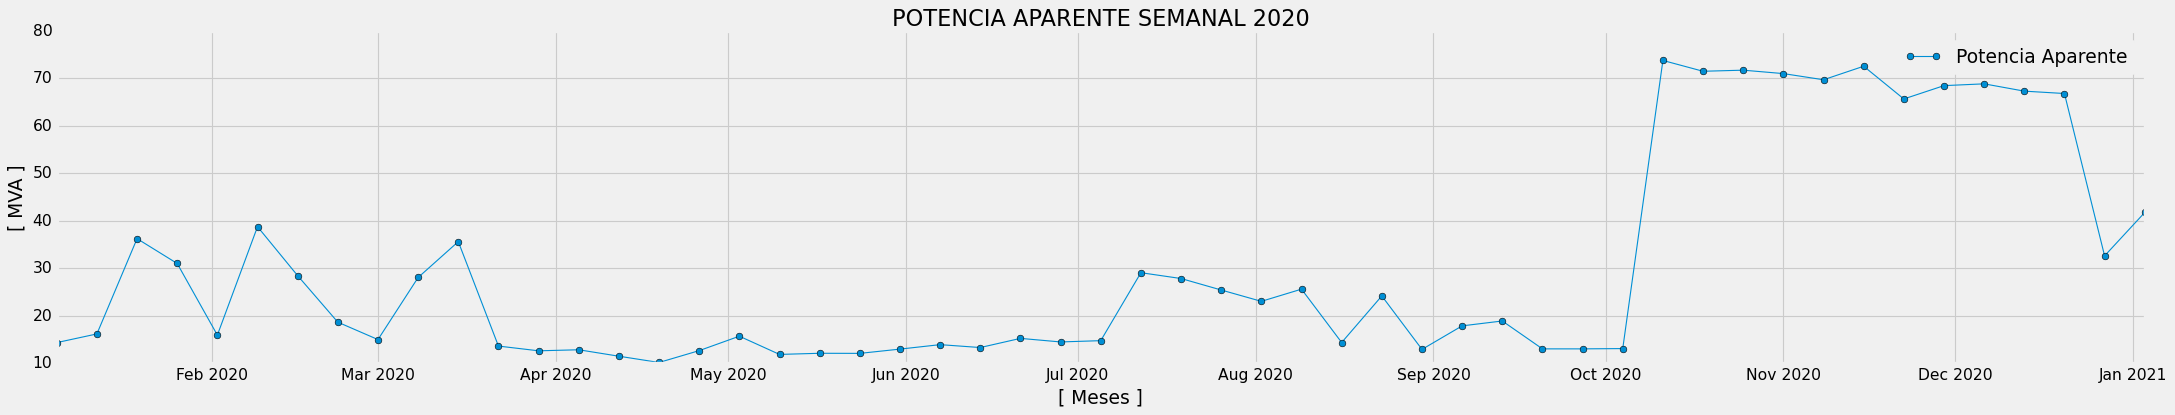

<Figure size 640x480 with 0 Axes>

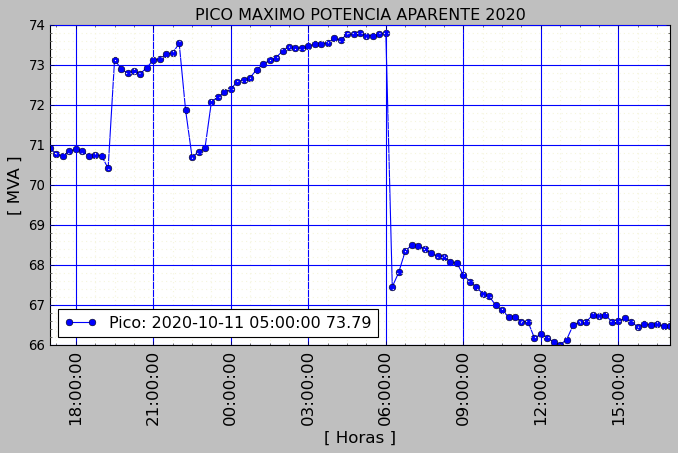

In [16]:
# LANZO LAS GRAFICAS 

Grafica_Todos_Anios_xSemana()

todos_anios = ['2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019', '2020']
for anio in todos_anios:
    Grafica_Anual_15min(anio)
    Grafica_Anual_xDia(anio)
    Grafica_Anual_xSemana(anio)
    Grafica_Pico_Anual(anio)

## Otro ejemplo de Pico Maximo en Diciembre 2018

In [19]:
indice_max = datos.loc['2018-12-01':'2018-12-31', 'MVA'].idxmax()
delta = pd.Timedelta('12 hours')
indice_mas12   = indice_max + delta
indice_menos12 = indice_max - delta
print(indice_menos12)
print(indice_max, datos.loc['2018-12-01':'2018-12-31', 'MVA'].max())
print(indice_mas12)

2018-12-11 01:15:00
2018-12-11 13:15:00 44.42
2018-12-12 01:15:00


In [ ]:
datos.loc['2018-12-01':'2018-12-31', 'MVA'].max()

In [ ]:
(46.42 + 44.42) / 2

<Figure size 432x288 with 0 Axes>

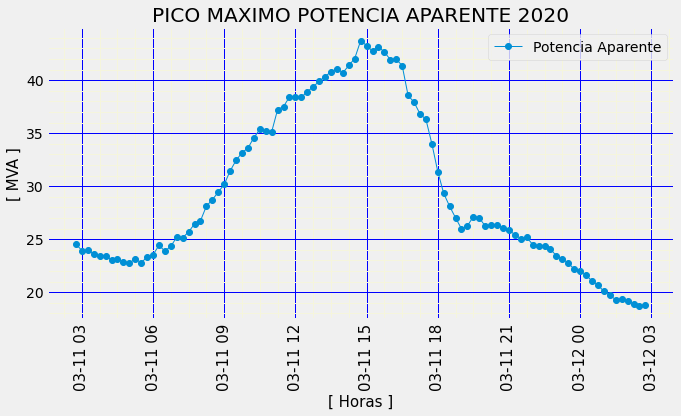

In [17]:
# GRAFICA DEL PICO MAXIMO POTENCIA APARENTE (CADA 15 MINUTOS) VENTANA 12 hs ANTES y 12 hs DESPUES

# CALCULO EL INDICE_MAX - 12 horas y el INDICE_MAX + 12 horas PARA LUEGO GRAFICAR
indice_max = datos.loc[anio:anio, 'MVA'].idxmax()
delta = pd.Timedelta('12 hours')
indice_mas12   = indice_max + delta  # 
indice_menos12 = indice_max - delta

y = datos.loc[indice_menos12 : indice_mas12, 'MVA']
x = y.index

fig = plt.figure()
fig, ax = plt.subplots(figsize=(10, 5))

ax.plot(x, y, lw=1, label='Potencia Aparente', marker='o')
ax.minorticks_on()
ax.grid(b=True, which='major', color='blue', alpha=1, linewidth=1, ls='-')
ax.grid(b=True, which='minor', color='beige', alpha=1, linewidth=1)


# Major Tick Label
# Minor Tick Label
plt.xticks(fontsize=15, rotation=90)

ax.set_xlabel('[ Horas ]', fontsize=15)  # Add an x-label to the axes.
ax.set_ylabel('[ MVA ]', fontsize=15)  # Add a y-label to the axes.
ax.set_title("PICO MAXIMO POTENCIA APARENTE " + anio)  # Add a title to the axes.
ax.legend()  # Add a legend.
#plt.style.use('classic')
#plt.style.use('seaborn')
#plt.style.use('ggplot')
#plt.show()


#grafico.annotate('Pico Max', xy=(01-31 14:45, 75), xytext=(01-31 15:00, 75), arrowprops=dict(facecolor='black', shrink=0.05)
#grafico.grid()
fig.savefig("Pico_Max.png")

### Borrar un timestamp de la Serie de Tiempo

In [22]:
foto = '2017-01-27 09:30:00'
datos.loc['2017-01-27', 'MVA']
datos.loc[foto, 'MVA']

75.78

In [24]:
datos = datos.drop(index=foto)

In [84]:
datos.loc['2020-10-07 08:45:00':'2020-12-14 14:45:00'].index

DatetimeIndex(['2020-10-07 08:45:00', '2020-10-07 09:00:00',
               '2020-10-07 09:15:00', '2020-10-07 09:30:00',
               '2020-10-07 09:45:00', '2020-10-07 10:00:00',
               '2020-10-07 10:15:00', '2020-10-07 10:30:00',
               '2020-10-07 10:45:00', '2020-10-07 11:00:00',
               ...
               '2020-12-14 12:30:00', '2020-12-14 12:45:00',
               '2020-12-14 13:00:00', '2020-12-14 13:15:00',
               '2020-12-14 13:30:00', '2020-12-14 13:45:00',
               '2020-12-14 14:00:00', '2020-12-14 14:15:00',
               '2020-12-14 14:30:00', '2020-12-14 14:45:00'],
              dtype='datetime64[ns]', name='Fecha_Hora', length=6503, freq=None)

In [86]:
datos = datos.drop(datos.loc['2020-10-07 08:45:00':'2020-12-14 14:45:00'].index)

In [87]:
datos

Fecha   Hora        MW     MVAR       MVA  \
Fecha_Hora                                                            
2010-01-01 00:15:00  01/01/2010  00:15 15.800000 7.130000 17.330000   
2010-01-01 00:30:00  01/01/2010  00:30 15.630000 6.820000 17.050000   
2010-01-01 00:45:00  01/01/2010  00:45 15.490000 6.800000 16.910000   
2010-01-01 01:00:00  01/01/2010  01:00 15.550000 6.810000 16.980000   
2010-01-01 01:15:00  01/01/2010  01:15 15.500000 6.820000 16.930000   
...                         ...    ...       ...      ...       ...   
2020-12-31 22:45:00  31/12/2020  22:45 16.490000 4.070000 16.980000   
2020-12-31 23:00:00  31/12/2020  23:00 16.320000 3.980000 16.800000   
2020-12-31 23:15:00  31/12/2020  23:15 16.210000 3.890000 16.670000   
2020-12-31 23:30:00  31/12/2020  23:30 16.220000 3.990000 16.700000   
2020-12-31 23:45:00  31/12/2020  23:45 16.100000 3.960000 16.580000   

                        Ampere    KVolt  
Fecha_Hora                               
2010-01-01 00:15:00 711.240000 0.000000  
2010-01-01 00:30:00 706.060000 0.000000  
2010-01-01 00:45:00 696.610000 0.000000  
2010-01-01 01:00:00 698.320000 0.000000  
2010-01-01 01:15:00 694.930000 0.000000  
...                        ...      ...  
2020-12-31 22:45:00 709.790000 2.220000  
2020-12-31 23:00:00 702.700000 2.220000  
2020-12-31 23:15:00 695.730000 2.220000  
2020-12-31 23:30:00 696.480000 2.230000  
2020-12-31 23:45:00 689.210000 2.230000  

[370081 rows x 7 columns]

In [92]:
datos.loc['2020-10': '2020-10'].head()

Fecha   Hora       MW      MVAR      MVA     Ampere  \
Fecha_Hora                                                                      
2020-10-01 00:00:00  30/09/2020  24:00 9.080000 -0.230000 9.080000 370.920000   
2020-10-01 00:15:00  01/10/2020  00:15 8.840000 -0.230000 8.840000 361.100000   
2020-10-01 00:30:00  01/10/2020  00:30 8.600000 -0.230000 8.610000 350.610000   
2020-10-01 00:45:00  01/10/2020  00:45 8.370000 -0.230000 8.380000 340.440000   
2020-10-01 01:00:00  01/10/2020  01:00 8.220000 -0.200000 8.220000 332.560000   

                       KVolt  
Fecha_Hora                    
2020-10-01 00:00:00 0.000000  
2020-10-01 00:15:00 0.000000  
2020-10-01 00:30:00 0.000000  
2020-10-01 00:45:00 0.000000  
2020-10-01 01:00:00 0.000000